In [ ]:
!pip install nb-black

In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import sys

sys.path.insert(0, "../")

## Dataset

In [5]:
import os
from typing import Dict, List, Tuple, Any, Union, Callable
from torch import Tensor
import torch
import numpy as np
import scipy
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.apply_func import apply_to_collection
from cspnn.data.bci.bci_dataset import BCI2aDataset
from cspnn.data.utils import eeg_electrode_configs

In [6]:
class ToTensor:
    def __init__(self, device):
        if isinstance(device, str):
            device = torch.device(device)
        self.device = device

    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.from_numpy(a),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.tensor(a, dtype=torch.float64),
        )

        return data, label


class ToNumpy:
    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )

        return data, label


class DictToTensor:
    def __call__(self, data: Dict[str, Tensor], label):
        # The output shape [batch, channel, signal]
        return (
            torch.permute(
                torch.vstack(list(map(lambda a: a.unsqueeze(0), data.values()))),
                (1, 0, 2),
            ),
            label,
        )


class DictToArray:
    def __call__(self, data, label):
        # The output shape [batch, channel, signal]
        return (
            np.transpose(
                np.vstack(
                    list(map(lambda a: np.expand_dims(a, axis=0), data.values()))
                ),
                (1, 0, 2),
            ),
            label,
        )


class Windowing:
    def __init__(self, n_segments: int = 5, sample_rate: float = 250.0):
        self.n_segments = n_segments
        self.sample_rate = sample_rate

    # The Output of the signal is [batch, channels, windowed, band_filtered, signal]
    def __call__(self, data: Tensor, label):
        """Takes as input a signal tensor of shape [batch, channels, band_filtered, signal]
        and outputs a signal tensor of shape [batch, channels, windowed, band_filtered, signal]
        """
        start, end = 0, data.size()[-1]
        step = int((end - start) / self.n_segments)
        windows = np.arange(start, end - step, step=step)

        if len(windows) == 0:
            data = data.unsqueeze(dim=2)
            return data, label

        windowed_data = torch.permute(
            torch.stack(
                [data[:, :, :, window : (window + step)] for window in windows], dim=0
            ),
            (1, 2, 0, 3, 4),
        )

        return windowed_data, label


class Filtering:
    def __init__(self, N: int, rs: float, Wns: List[float], bandwidth, fs: float):
        self.N = N
        self.rs = rs
        self.Wns = Wns / (fs / 2)  # Normalize the signals
        self.bandwidth = bandwidth / (fs / 2)  # Normalize the signals
        self.fs = fs

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = []

        for wn in self.Wns:
            b, a = scipy.signal.cheby2(
                N=self.N,
                rs=self.rs,
                Wn=[wn, wn + self.bandwidth],
                btype="bandpass",
                fs=self.fs,
            )
            filtered_data.append(scipy.signal.filtfilt(b, a, data, axis=-1))

        filtered_data = torch.permute(torch.Tensor(filtered_data), (1, 2, 0, 3))

        return filtered_data, label


class ExpandDim(object):
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, data, label):
        return data.unsqueeze_(self.dim), label


class LabelToDict:
    def __call__(self, data, label):
        return data, {"label": label}


class ToNumpy:
    def __call__(self, data, label):
        return data.cpu().detach().numpy(), label.cpu().detach().numpy()


class Compose:
    def __init__(self, transforms: List[Callable]) -> None:
        self.transforms = transforms

    def __call__(self, data: Any, target: Any):
        for t in self.transforms:
            data, target = t(data, target)
        return data, target

    def __repr__(self):
        return "\n".join([c.__class__.__name__ for c in self.transforms])


# TODO: complete this part
from scipy.signal import cheby2, filtfilt


def cheby_bandpass_filter(signal, attenuation, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cheby2(order, rs=attenuation, Wn=[low, high], btype="band")
    y = filtfilt(b, a, signal, axis=-1)
    # print("filtered shape ", y.shape)
    return y


def cheby_bandpass_one_subject(
    X, attenuation, lowcut, highcut, fs, interval=None, verbose=True
):
    temp_epoch_EEG = X.copy()
    # print(f"data shape : {temp_epoch_EEG.shape}")

    if interval is not None:
        startband = np.arange(lowcut, highcut, step=interval)

        bands = []
        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start + interval)

            if verbose:
                print("Filtering through {} Hz band".format(band))
            # Bandpass filtering
            bands.append(
                cheby_bandpass_filter(
                    temp_epoch_EEG, attenuation, start, start + interval, fs
                )
            )

        return np.vstack(bands)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        return cheby_bandpass_filter(temp_epoch_EEG, attenuation, lowcut, highcut, fs)


from functools import partial


class BandPass:
    def __init__(self, attenuation, lowcut, highcut, fs, interval=None):
        self.attenuation = attenuation
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.interval = interval

        self.bandpass_func = partial(
            cheby_bandpass_one_subject,
            attenuation=self.attenuation,
            lowcut=self.lowcut,
            highcut=self.highcut,
            fs=self.fs,
            interval=self.interval,
            verbose=False,
        )

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64, Tensor),
            function=self.bandpass_func,
        )

        filtered_data = np.expand_dims(filtered_data.transpose(1, 0, 2), axis=0)

        return filtered_data, label

In [8]:
directory = "../test_data"
electrod_positions, shape = eeg_electrode_configs(
    "../configs/eeg_recording_standard/international_10_20_22.py"
)
if not os.path.exists(directory):
    os.makedirs(directory)


fs = 250
low_freq = 4
high_freq = 38
bandwidth = 4
overlap = 2

freqs = np.arange(low_freq, high_freq - (bandwidth - overlap), overlap)

lowcut = 4
highcut = 40
fs = 250
attenuation = 40
interval = 4

transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    # ToNumpy(),
    # BandPass(
    #     attenuation=attenuation,
    #     lowcut=lowcut,
    #     highcut=highcut,
    #     fs=fs,
    #     interval=interval,
    # ),
    # ToTensor(device="cpu"),
    # Filtering(N=4, rs=40, Wns=freqs, bandwidth=bandwidth, fs=fs),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    # Windowing(n_segments=1),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
    patients=[1],
    in_mem=True,
)

In [9]:
for i in range(len(ds)):
    wave, label = ds[i]
    print(wave.min(), wave.max())
    print(wave.shape)
    if np.isnan(wave).any() or np.isinf(wave).any():
        print(f"date {i} : has NAN or INF")
    break

tensor(-22.1658, dtype=torch.float64) tensor(18.0601, dtype=torch.float64)
torch.Size([1, 22, 1, 1, 1001])


In [10]:
def collate_fn(batch):
    imgs = torch.vstack([item[0] for item in batch])

    trgts = {}
    sample_item_label = batch[0][1]
    for label_key in sample_item_label.keys():
        if isinstance(sample_item_label[label_key], dict):
            trgts[label_key] = {
                key: torch.vstack([item[1][label_key][key].squeeze() for item in batch])
                for key in sample_item_label[label_key].keys()
            }
        else:
            trgts[label_key] = torch.vstack(
                [item[1][label_key] for item in batch]
            ).squeeze()

    return [imgs, trgts]

In [11]:
batch_size = 32
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

## Model

In [12]:
import torch
import numpy as np
import torch.nn as nn
from cspnn.csp_nn import CSP, CSPNN

In [13]:
import torch.optim as optim

In [14]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    cohen_kappa_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import random

In [17]:
class CSPNNCls(nn.Module):
    def __init__(
        self,
        num_channels: int,
        num_features: int = None,
        num_bands: int = None,
        num_windows: int = 1,
        num_labels: int = None,
        mode: str = "constant",
    ):
        super(CSPNNCls, self).__init__()
        self.num_channels = num_channels
        self.num_features = num_channels if num_features is None else num_features
        self.num_bands = num_bands
        self.num_windows = num_windows
        self.num_labels = num_labels
        self.mode = mode

        self.conv1 = CSPNN(
            num_channels=num_channels,
            num_features=num_features,
            num_bands=num_bands,
            num_windows=num_windows,
            num_labels=num_labels,
            mode=self.mode,
        )

        conv2d_batch_out_channels_1 = 40

        self.conv2d_1 = nn.Conv2d(
            in_channels=1,
            out_channels=conv2d_batch_out_channels_1,
            kernel_size=(1, 1),
            padding="same",
            stride=1,
        )

        self.batch_norm_1 = nn.BatchNorm2d(num_features=conv2d_batch_out_channels_1)

        self.activation = nn.ReLU()

        conv2d_batch_out_channels_2 = 40

        self.conv2d_2 = nn.Conv2d(
            in_channels=1,
            out_channels=conv2d_batch_out_channels_2,
            kernel_size=(1, 1),
            padding="same",
            stride=1,
        )

        self.batch_norm_2 = nn.BatchNorm2d(num_features=conv2d_batch_out_channels_2)

        self.flatten = nn.Flatten()

        drop_out_1 = 0.3
        self.drop_out_1 = nn.Dropout(p=drop_out_1)

        self.fc1 = nn.Linear(3520, 40)

        drop_out_2 = 0.2
        self.drop_out_2 = nn.Dropout(p=drop_out_2)

        self.fc2 = nn.Linear(40, 10)

        self.fc = nn.Linear(10, 4)

    def forward(self, x):
        csp = self.conv1(x)

        features = csp.reshape(
            (
                -1,
                self.num_bands * self.num_windows * self.num_labels * self.num_features,
            )
        )

        features = features.unsqueeze_(1)
        features = features.unsqueeze_(-1)

        x = self.conv2d_1(features)
        x = self.batch_norm_1(x)
        x = self.activation(x)

        x = self.conv2d_2(features)
        x = self.batch_norm_2(x)
        x = self.activation(x)

        x = self.flatten(x)

        # print(f"{x.size() = }")

        x = self.drop_out_1(x)
        x = self.fc1(x)
        x = self.activation(x)

        x = self.drop_out_2(x)
        x = self.fc2(x)
        x = self.activation(x)

        x = F.softmax(self.fc(x), dim=1)
        if self.training:
            return x, csp
        return x


net = CSPNNCls(
    num_channels=22,
    num_features=22,
    num_bands=1,
    num_windows=1,
    num_labels=4,
    mode="csp",
)
# .cuda(0)
cls_criterion = nn.CrossEntropyLoss()  # nn.BCELoss()
# reg_criterion = nn.MSELoss()
# optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00)
optimizer = optim.SGD(
    net.parameters(), lr=0.001, momentum=0.9, nesterov=True, weight_decay=0
)

# optimizer = optim.SGD(
#     [
#         {"params": net.conv1.parameters()},
#         {"params": net.fc1.parameters(), "weight_decay": 5e-3},
#         {"params": net.fc.parameters()},
#     ],
#     lr=0.001,
#     momentum=0.9,
#     nesterov=True,
#     weight_decay=0,
# )

# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.1, steps_per_epoch=1, epochs=200
# )
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

In [19]:
signals = torch.empty((10, 22, 1, 16, 769), dtype=torch.float32).random_(1, 50)
# signals = signals.to("cuda")
a, b = net(signals)
a.size(), b.size()

(torch.Size([10, 4]), torch.Size([10, 4, 22]))

## Train Loop

In [24]:
net = net.cuda()
# net = net.to("cuda")
# net

In [22]:
def evaluate(model, dl, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results

In [25]:
history = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "train_kappa": [],
    "test_kappa": [],
    "train_fmeasure": [],
    "test_fmeasure": [],
    "lr": [],
}
batch_size = 32
alpha = 0.5

for epoch in range(1000):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)

    net.train()
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader)):
        # print(i)
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )

        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, csp_out = net(inputs.float().cuda(0))
        cls_loss = cls_criterion(
            outputs, labels["label"].type(torch.LongTensor).cuda(0)
        )
        # reg_loss = reg_criterion(csp, labels["csp"].cuda(0))
        # loss = cls_loss + (alpha * reg_loss)
        loss = cls_loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    history["lr"].append(optimizer.param_groups[0]["lr"])
    # print(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

    # Validation accuracy
    # params = ["acc", "kappa", "auc", "fmeasure", "loss"]
    params = ["acc", "kappa", "fmeasure", "loss"]
    print(params)
    print("Training Loss ", running_loss / len(train_dataloader))
    tr = evaluate(net, train_dataloader, params)
    print("Train - ", tr)
    ev = evaluate(net, val_dataloader, params)
    print("Validation - ", ev)
    history["train_loss"].append(tr[-1])
    history["train_acc"].append(tr[0])
    history["train_kappa"].append(tr[1])
    history["train_fmeasure"].append(tr[2])

    history["test_loss"].append(ev[-1])
    history["test_acc"].append(ev[0])
    history["test_kappa"].append(ev[1])
    history["test_fmeasure"].append(ev[2])


Epoch  0


9it [00:00, 13.18it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3889193534851074


Train -  [0.24305555555555555, -0.0092592592592593, 0.24305555555555555, tensor(1.3881)]
Validation -  [0.2361111111111111, -0.0185185185185186, 0.2361111111111111, tensor(1.3883)]

Epoch  1


9it [00:00, 18.07it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3879499700334337


Train -  [0.21875, -0.04166666666666674, 0.21875, tensor(1.3882)]
Validation -  [0.2152777777777778, -0.04629629629629628, 0.2152777777777778, tensor(1.3884)]

Epoch  2


9it [00:00, 16.56it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3888564109802246


Train -  [0.25, 0.0, 0.25, tensor(1.3881)]
Validation -  [0.25, 0.0, 0.25, tensor(1.3883)]

Epoch  3


9it [00:00, 15.70it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3891959057913885


Train -  [0.25, 0.0, 0.25, tensor(1.3880)]
Validation -  [0.2465277777777778, -0.004629629629629539, 0.2465277777777778, tensor(1.3883)]

Epoch  4


9it [00:00, 15.52it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3879732025994196


Train -  [0.25, 0.0, 0.25, tensor(1.3880)]
Validation -  [0.2465277777777778, -0.004629629629629539, 0.2465277777777778, tensor(1.3882)]

Epoch  5


9it [00:00, 16.96it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3882777955796983


Train -  [0.3020833333333333, 0.06944444444444442, 0.3020833333333333, tensor(1.3881)]
Validation -  [0.28125, 0.04166666666666663, 0.28125, tensor(1.3882)]

Epoch  6


9it [00:00, 17.35it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3881196578343709


Train -  [0.3090277777777778, 0.07870370370370372, 0.3090277777777778, tensor(1.3881)]
Validation -  [0.3159722222222222, 0.08796296296296291, 0.3159722222222222, tensor(1.3882)]

Epoch  7


9it [00:00, 17.03it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3882954120635986


Train -  [0.2604166666666667, 0.01388888888888884, 0.2604166666666667, tensor(1.3880)]
Validation -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3882)]

Epoch  8


9it [00:00, 16.70it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3887366188897028


Train -  [0.2604166666666667, 0.01388888888888884, 0.2604166666666667, tensor(1.3880)]
Validation -  [0.2569444444444444, 0.0092592592592593, 0.2569444444444444, tensor(1.3881)]

Epoch  9


9it [00:00, 15.34it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.387839674949646


Train -  [0.3298611111111111, 0.10648148148148151, 0.3298611111111111, tensor(1.3877)]
Validation -  [0.3020833333333333, 0.06944444444444442, 0.3020833333333333, tensor(1.3880)]

Epoch  10


9it [00:00, 15.45it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3877630101309881


Train -  [0.3819444444444444, 0.17592592592592593, 0.3819444444444445, tensor(1.3875)]
Validation -  [0.2916666666666667, 0.05555555555555558, 0.2916666666666667, tensor(1.3878)]

Epoch  11


9it [00:00, 13.45it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3883302741580539


Train -  [0.3263888888888889, 0.10185185185185186, 0.3263888888888889, tensor(1.3873)]
Validation -  [0.3090277777777778, 0.07870370370370372, 0.3090277777777778, tensor(1.3876)]

Epoch  12


9it [00:00, 15.86it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3871108161078558


Train -  [0.3680555555555556, 0.15740740740740744, 0.36805555555555564, tensor(1.3872)]
Validation -  [0.3229166666666667, 0.09722222222222221, 0.3229166666666667, tensor(1.3875)]

Epoch  13


9it [00:00, 17.79it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3873825073242188


Train -  [0.3402777777777778, 0.12037037037037035, 0.3402777777777778, tensor(1.3872)]
Validation -  [0.3402777777777778, 0.12037037037037035, 0.3402777777777778, tensor(1.3874)]

Epoch  14


9it [00:00, 16.57it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.386968904071384


Train -  [0.2569444444444444, 0.0092592592592593, 0.2569444444444444, tensor(1.3871)]
Validation -  [0.2777777777777778, 0.03703703703703709, 0.2777777777777778, tensor(1.3874)]

Epoch  15


9it [00:00, 12.88it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.387112922138638


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3871)]
Validation -  [0.2569444444444444, 0.0092592592592593, 0.2569444444444444, tensor(1.3874)]

Epoch  16


9it [00:00, 18.77it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3876779874165852


Train -  [0.25, 0.0, 0.25, tensor(1.3870)]
Validation -  [0.2465277777777778, -0.004629629629629539, 0.2465277777777778, tensor(1.3873)]

Epoch  17


9it [00:00, 17.17it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3864828613069322


Train -  [0.25, 0.0, 0.25, tensor(1.3868)]
Validation -  [0.2465277777777778, -0.004629629629629539, 0.2465277777777778, tensor(1.3872)]

Epoch  18


9it [00:00, 15.38it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.385845250553555


Train -  [0.25, 0.0, 0.25, tensor(1.3865)]
Validation -  [0.2465277777777778, -0.004629629629629539, 0.2465277777777778, tensor(1.3870)]

Epoch  19


9it [00:00, 14.87it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3874999814563327


Train -  [0.25, 0.0, 0.25, tensor(1.3863)]
Validation -  [0.2465277777777778, -0.004629629629629539, 0.2465277777777778, tensor(1.3867)]

Epoch  20


9it [00:00, 17.06it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.386360724767049


Train -  [0.25, 0.0, 0.25, tensor(1.3862)]
Validation -  [0.2465277777777778, -0.004629629629629539, 0.2465277777777778, tensor(1.3866)]

Epoch  21


9it [00:00, 18.76it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3858823378880818


Train -  [0.25, 0.0, 0.25, tensor(1.3860)]
Validation -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3864)]

Epoch  22


9it [00:00, 16.40it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3854936096403334


Train -  [0.2569444444444444, 0.0092592592592593, 0.2569444444444444, tensor(1.3858)]
Validation -  [0.2638888888888889, 0.01851851851851849, 0.2638888888888889, tensor(1.3862)]

Epoch  23


9it [00:00, 16.62it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3881215916739569


Train -  [0.2569444444444444, 0.0092592592592593, 0.2569444444444444, tensor(1.3856)]
Validation -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3860)]

Epoch  24


9it [00:00, 16.15it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3853955003950331


Train -  [0.25, 0.0, 0.25, tensor(1.3853)]
Validation -  [0.25, 0.0, 0.25, tensor(1.3858)]

Epoch  25


9it [00:00, 16.07it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3863825135760837


Train -  [0.25, 0.0, 0.25, tensor(1.3851)]
Validation -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3855)]

Epoch  26


9it [00:00, 15.81it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.387139704492357


Train -  [0.25, 0.0, 0.25, tensor(1.3850)]
Validation -  [0.2465277777777778, -0.004629629629629539, 0.2465277777777778, tensor(1.3854)]

Epoch  27


9it [00:00, 14.26it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3845916324191623


Train -  [0.25, 0.0, 0.25, tensor(1.3849)]
Validation -  [0.25, 0.0, 0.25, tensor(1.3853)]

Epoch  28


9it [00:00, 18.63it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3856980270809598


Train -  [0.25, 0.0, 0.25, tensor(1.3847)]
Validation -  [0.2465277777777778, -0.004629629629629539, 0.2465277777777778, tensor(1.3850)]

Epoch  29


9it [00:00, 16.05it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3863285647498236


Train -  [0.25, 0.0, 0.25, tensor(1.3845)]
Validation -  [0.2465277777777778, -0.004629629629629539, 0.2465277777777778, tensor(1.3849)]

Epoch  30


9it [00:00, 15.25it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3857831690046523


Train -  [0.25, 0.0, 0.25, tensor(1.3843)]
Validation -  [0.2465277777777778, -0.004629629629629539, 0.2465277777777778, tensor(1.3846)]

Epoch  31


9it [00:00, 18.60it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.384881059328715


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3841)]
Validation -  [0.25, 0.0, 0.25, tensor(1.3844)]

Epoch  32


9it [00:00, 15.29it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3851990169949002


Train -  [0.25, 0.0, 0.25, tensor(1.3839)]
Validation -  [0.25, 0.0, 0.25, tensor(1.3842)]

Epoch  33


9it [00:00, 15.58it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3845604128307767


Train -  [0.25, 0.0, 0.25, tensor(1.3838)]
Validation -  [0.25, 0.0, 0.25, tensor(1.3840)]

Epoch  34


9it [00:00, 14.21it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3858706288867526


Train -  [0.25, 0.0, 0.25, tensor(1.3835)]
Validation -  [0.25, 0.0, 0.25, tensor(1.3837)]

Epoch  35


9it [00:00, 14.77it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3852001428604126


Train -  [0.25, 0.0, 0.25, tensor(1.3833)]
Validation -  [0.25, 0.0, 0.25, tensor(1.3835)]

Epoch  36


9it [00:00, 16.80it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3849424653583102


Train -  [0.25, 0.0, 0.25, tensor(1.3831)]
Validation -  [0.25, 0.0, 0.25, tensor(1.3833)]

Epoch  37


9it [00:00, 18.93it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3859392669465807


Train -  [0.25, 0.0, 0.25, tensor(1.3827)]
Validation -  [0.25, 0.0, 0.25, tensor(1.3828)]

Epoch  38


9it [00:00, 16.22it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3839231861962213


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3825)]
Validation -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3826)]

Epoch  39


9it [00:00, 14.21it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3847313589519925


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3822)]
Validation -  [0.2569444444444444, 0.0092592592592593, 0.2569444444444444, tensor(1.3823)]

Epoch  40


9it [00:00, 15.28it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3823003504011366


Train -  [0.25, 0.0, 0.25, tensor(1.3820)]
Validation -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3820)]

Epoch  41


9it [00:00, 16.05it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3826247056325276


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3817)]
Validation -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3817)]

Epoch  42


9it [00:00, 16.63it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3829561604393854


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3814)]
Validation -  [0.2569444444444444, 0.0092592592592593, 0.2569444444444444, tensor(1.3813)]

Epoch  43


9it [00:00, 18.01it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.382426420847575


Train -  [0.25, 0.0, 0.25, tensor(1.3813)]
Validation -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3812)]

Epoch  44


9it [00:00, 14.94it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3823663261201646


Train -  [0.25, 0.0, 0.25, tensor(1.3810)]
Validation -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3809)]

Epoch  45


9it [00:00, 15.79it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3820752302805583


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3806)]
Validation -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3804)]

Epoch  46


9it [00:00, 16.92it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3817100259992812


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3802)]
Validation -  [0.2604166666666667, 0.01388888888888884, 0.2604166666666667, tensor(1.3799)]

Epoch  47


9it [00:00, 15.09it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3810985088348389


Train -  [0.25, 0.0, 0.25, tensor(1.3801)]
Validation -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3798)]

Epoch  48


9it [00:00, 15.27it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.380538238419427


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3797)]
Validation -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3794)]

Epoch  49


9it [00:00, 19.97it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.380142953660753


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3792)]
Validation -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3789)]

Epoch  50


9it [00:00, 17.41it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3800363805558946


Train -  [0.25, 0.0, 0.25, tensor(1.3789)]
Validation -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3786)]

Epoch  51


9it [00:00, 14.90it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3814338313208685


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3784)]
Validation -  [0.2569444444444444, 0.0092592592592593, 0.2569444444444444, tensor(1.3780)]

Epoch  52


9it [00:00, 19.18it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3804790178934734


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3781)]
Validation -  [0.2569444444444444, 0.0092592592592593, 0.2569444444444444, tensor(1.3776)]

Epoch  53


9it [00:00, 16.45it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3805810610453289


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3777)]
Validation -  [0.2604166666666667, 0.01388888888888884, 0.2604166666666667, tensor(1.3771)]

Epoch  54


9it [00:00, 13.51it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3773037592569988


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3773)]
Validation -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3768)]

Epoch  55


9it [00:00, 15.50it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3786832226647272


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3768)]
Validation -  [0.2604166666666667, 0.01388888888888884, 0.2604166666666667, tensor(1.3762)]

Epoch  56


9it [00:00, 14.67it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3789305422041152


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3764)]
Validation -  [0.2604166666666667, 0.01388888888888884, 0.2604166666666667, tensor(1.3757)]

Epoch  57


9it [00:00, 15.25it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3776488569047716


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3761)]
Validation -  [0.2569444444444444, 0.0092592592592593, 0.2569444444444444, tensor(1.3753)]

Epoch  58


9it [00:00, 17.56it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3786701228883531


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3757)]
Validation -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3749)]

Epoch  59


9it [00:00, 15.54it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3778273397021823


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3750)]
Validation -  [0.2604166666666667, 0.01388888888888884, 0.2604166666666667, tensor(1.3742)]

Epoch  60


9it [00:00, 18.13it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3771441645092435


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3746)]
Validation -  [0.2569444444444444, 0.0092592592592593, 0.2569444444444444, tensor(1.3737)]

Epoch  61


9it [00:00, 14.37it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3748498095406427


Train -  [0.2569444444444444, 0.0092592592592593, 0.2569444444444444, tensor(1.3739)]
Validation -  [0.2673611111111111, 0.02314814814814814, 0.2673611111111111, tensor(1.3730)]

Epoch  62


9it [00:00, 15.68it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3746114042070177


Train -  [0.2569444444444444, 0.0092592592592593, 0.2569444444444444, tensor(1.3734)]
Validation -  [0.2604166666666667, 0.01388888888888884, 0.2604166666666667, tensor(1.3724)]

Epoch  63


9it [00:00, 15.50it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3766286770502727
Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3729)]
Validation -  [0.2604166666666667, 0.01388888888888884, 0.2604166666666667, tensor(1.3719)]

Epoch  64


9it [00:00, 17.85it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.376697646247016


Train -  [0.2569444444444444, 0.0092592592592593, 0.2569444444444444, tensor(1.3724)]
Validation -  [0.2604166666666667, 0.01388888888888884, 0.2604166666666667, tensor(1.3713)]

Epoch  65


9it [00:00, 17.26it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3743127054638333


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3720)]
Validation -  [0.2604166666666667, 0.01388888888888884, 0.2604166666666667, tensor(1.3709)]

Epoch  66


9it [00:00, 16.30it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.373336010509067


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3714)]
Validation -  [0.2604166666666667, 0.01388888888888884, 0.2604166666666667, tensor(1.3702)]

Epoch  67


9it [00:00, 17.43it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3716116746266682


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3709)]
Validation -  [0.2604166666666667, 0.01388888888888884, 0.2604166666666667, tensor(1.3697)]

Epoch  68


9it [00:00, 15.98it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.372117492887709


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3702)]
Validation -  [0.2604166666666667, 0.01388888888888884, 0.2604166666666667, tensor(1.3690)]

Epoch  69


9it [00:00, 14.85it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3688643508487277


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3695)]
Validation -  [0.2604166666666667, 0.01388888888888884, 0.2604166666666667, tensor(1.3683)]

Epoch  70


9it [00:00, 15.67it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3700283898247614


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3688)]
Validation -  [0.2604166666666667, 0.01388888888888884, 0.2604166666666667, tensor(1.3676)]

Epoch  71


9it [00:00, 19.15it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3689334127638075


Train -  [0.2569444444444444, 0.0092592592592593, 0.2569444444444444, tensor(1.3681)]
Validation -  [0.2604166666666667, 0.01388888888888884, 0.2604166666666667, tensor(1.3668)]

Epoch  72


9it [00:00, 15.85it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3688356479008992


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3676)]
Validation -  [0.2604166666666667, 0.01388888888888884, 0.2604166666666667, tensor(1.3662)]

Epoch  73


9it [00:00, 14.82it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3677356905407376


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3667)]
Validation -  [0.2604166666666667, 0.01388888888888884, 0.2604166666666667, tensor(1.3654)]

Epoch  74


9it [00:00, 15.39it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3674307134416368


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3662)]
Validation -  [0.2604166666666667, 0.01388888888888884, 0.2604166666666667, tensor(1.3647)]

Epoch  75


9it [00:00, 15.68it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3673985534244113


Train -  [0.2534722222222222, 0.00462962962962965, 0.2534722222222222, tensor(1.3651)]
Validation -  [0.2604166666666667, 0.01388888888888884, 0.2604166666666667, tensor(1.3637)]

Epoch  76


9it [00:00, 16.47it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.367660469479031


Train -  [0.2569444444444444, 0.0092592592592593, 0.2569444444444444, tensor(1.3640)]
Validation -  [0.2638888888888889, 0.01851851851851849, 0.2638888888888889, tensor(1.3626)]

Epoch  77


9it [00:00, 18.60it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3631420930226643


Train -  [0.2638888888888889, 0.01851851851851849, 0.2638888888888889, tensor(1.3633)]
Validation -  [0.2881944444444444, 0.05092592592592593, 0.2881944444444444, tensor(1.3619)]

Epoch  78


9it [00:00, 18.58it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.363088051478068


Train -  [0.2638888888888889, 0.01851851851851849, 0.2638888888888889, tensor(1.3624)]
Validation -  [0.2743055555555556, 0.03240740740740744, 0.2743055555555556, tensor(1.3608)]

Epoch  79


9it [00:00, 14.48it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3621558878156874


Train -  [0.2569444444444444, 0.0092592592592593, 0.2569444444444444, tensor(1.3620)]
Validation -  [0.2638888888888889, 0.01851851851851849, 0.2638888888888889, tensor(1.3603)]

Epoch  80


9it [00:00, 14.25it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3689820633994207


Train -  [0.2569444444444444, 0.0092592592592593, 0.2569444444444444, tensor(1.3607)]
Validation -  [0.2743055555555556, 0.03240740740740744, 0.2743055555555556, tensor(1.3590)]

Epoch  81


9it [00:00, 17.66it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3628098434872098


Train -  [0.2638888888888889, 0.01851851851851849, 0.2638888888888889, tensor(1.3596)]
Validation -  [0.2881944444444444, 0.05092592592592593, 0.2881944444444444, tensor(1.3579)]

Epoch  82


9it [00:00, 16.43it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3624961773554485


Train -  [0.2638888888888889, 0.01851851851851849, 0.2638888888888889, tensor(1.3586)]
Validation -  [0.2881944444444444, 0.05092592592592593, 0.2881944444444444, tensor(1.3569)]

Epoch  83


9it [00:00, 14.14it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3641315301259358


Train -  [0.2638888888888889, 0.01851851851851849, 0.2638888888888889, tensor(1.3576)]
Validation -  [0.2847222222222222, 0.04629629629629628, 0.2847222222222222, tensor(1.3559)]

Epoch  84


9it [00:00, 15.05it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3585802846484714


Train -  [0.2569444444444444, 0.0092592592592593, 0.2569444444444444, tensor(1.3567)]
Validation -  [0.2604166666666667, 0.01388888888888884, 0.2604166666666667, tensor(1.3551)]

Epoch  85


9it [00:00, 16.58it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3661677440007527


Train -  [0.2638888888888889, 0.01851851851851849, 0.2638888888888889, tensor(1.3556)]
Validation -  [0.2847222222222222, 0.04629629629629628, 0.2847222222222222, tensor(1.3540)]

Epoch  86


9it [00:00, 17.87it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3563672966427274


Train -  [0.2638888888888889, 0.01851851851851849, 0.2638888888888889, tensor(1.3546)]
Validation -  [0.2777777777777778, 0.03703703703703709, 0.2777777777777778, tensor(1.3529)]

Epoch  87


9it [00:00, 15.27it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3600029548009236


Train -  [0.2673611111111111, 0.02314814814814814, 0.2673611111111111, tensor(1.3533)]
Validation -  [0.2916666666666667, 0.05555555555555558, 0.2916666666666667, tensor(1.3516)]

Epoch  88


9it [00:00, 16.65it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3570418225394354


Train -  [0.2638888888888889, 0.01851851851851849, 0.2638888888888889, tensor(1.3521)]
Validation -  [0.2881944444444444, 0.05092592592592593, 0.2881944444444444, tensor(1.3503)]

Epoch  89


9it [00:00, 17.34it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.350876013437907


Train -  [0.2638888888888889, 0.01851851851851849, 0.2638888888888889, tensor(1.3506)]
Validation -  [0.2951388888888889, 0.06018518518518523, 0.2951388888888889, tensor(1.3488)]

Epoch  90


9it [00:00, 15.94it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3531341287824843


Train -  [0.2881944444444444, 0.05092592592592593, 0.2881944444444444, tensor(1.3491)]
Validation -  [0.3055555555555556, 0.07407407407407407, 0.3055555555555556, tensor(1.3472)]

Epoch  91


9it [00:00, 16.46it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3522650400797527


Train -  [0.3229166666666667, 0.09722222222222221, 0.3229166666666667, tensor(1.3471)]
Validation -  [0.3541666666666667, 0.13888888888888884, 0.3541666666666667, tensor(1.3453)]

Epoch  92


9it [00:00, 17.17it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3558525111940172


Train -  [0.34375, 0.125, 0.34375, tensor(1.3457)]
Validation -  [0.3680555555555556, 0.15740740740740744, 0.36805555555555564, tensor(1.3438)]

Epoch  93


9it [00:00, 15.58it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.348756194114685


Train -  [0.3506944444444444, 0.1342592592592593, 0.3506944444444444, tensor(1.3443)]
Validation -  [0.3784722222222222, 0.17129629629629628, 0.3784722222222222, tensor(1.3423)]

Epoch  94


9it [00:00, 17.37it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3492129113939073


Train -  [0.3263888888888889, 0.10185185185185186, 0.3263888888888889, tensor(1.3426)]
Validation -  [0.3645833333333333, 0.1527777777777778, 0.36458333333333326, tensor(1.3405)]

Epoch  95


9it [00:00, 14.62it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3506651322046916


Train -  [0.3611111111111111, 0.14814814814814814, 0.3611111111111111, tensor(1.3409)]
Validation -  [0.3784722222222222, 0.17129629629629628, 0.3784722222222222, tensor(1.3388)]

Epoch  96


9it [00:00, 15.70it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3489906787872314


Train -  [0.3680555555555556, 0.15740740740740744, 0.36805555555555564, tensor(1.3399)]
Validation -  [0.3958333333333333, 0.19444444444444442, 0.3958333333333333, tensor(1.3378)]

Epoch  97


9it [00:00, 20.15it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3459126949310303


Train -  [0.3784722222222222, 0.17129629629629628, 0.3784722222222222, tensor(1.3376)]
Validation -  [0.4097222222222222, 0.2129629629629629, 0.4097222222222222, tensor(1.3355)]

Epoch  98


9it [00:00, 13.73it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3413602511088054


Train -  [0.3923611111111111, 0.18981481481481477, 0.3923611111111111, tensor(1.3359)]
Validation -  [0.4201388888888889, 0.22685185185185186, 0.4201388888888889, tensor(1.3337)]

Epoch  99


9it [00:00, 17.45it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3429771661758423


Train -  [0.3888888888888889, 0.18518518518518523, 0.3888888888888889, tensor(1.3340)]
Validation -  [0.4166666666666667, 0.2222222222222222, 0.4166666666666667, tensor(1.3319)]

Epoch  100


9it [00:00, 15.26it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3380656639734905


Train -  [0.4097222222222222, 0.2129629629629629, 0.4097222222222222, tensor(1.3322)]
Validation -  [0.4201388888888889, 0.22685185185185186, 0.4201388888888889, tensor(1.3300)]

Epoch  101


9it [00:00, 17.96it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.343638022740682


Train -  [0.4131944444444444, 0.21759259259259256, 0.4131944444444444, tensor(1.3304)]
Validation -  [0.4236111111111111, 0.2314814814814815, 0.4236111111111111, tensor(1.3281)]

Epoch  102


9it [00:00, 17.05it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3390864663653903


Train -  [0.4236111111111111, 0.2314814814814815, 0.4236111111111111, tensor(1.3287)]
Validation -  [0.4236111111111111, 0.2314814814814815, 0.4236111111111111, tensor(1.3264)]

Epoch  103


9it [00:00, 15.68it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3356514241960313


Train -  [0.4097222222222222, 0.2129629629629629, 0.4097222222222222, tensor(1.3268)]
Validation -  [0.4166666666666667, 0.2222222222222222, 0.4166666666666667, tensor(1.3245)]

Epoch  104


9it [00:00, 15.24it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.334119478861491


Train -  [0.4131944444444444, 0.21759259259259256, 0.4131944444444444, tensor(1.3248)]
Validation -  [0.4166666666666667, 0.2222222222222222, 0.4166666666666667, tensor(1.3225)]

Epoch  105


9it [00:00, 14.69it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3276649316151936


Train -  [0.4166666666666667, 0.2222222222222222, 0.4166666666666667, tensor(1.3225)]
Validation -  [0.4236111111111111, 0.2314814814814815, 0.4236111111111111, tensor(1.3202)]

Epoch  106


9it [00:00, 15.12it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3223773108588324


Train -  [0.4270833333333333, 0.23611111111111116, 0.4270833333333333, tensor(1.3204)]
Validation -  [0.4305555555555556, 0.2407407407407407, 0.4305555555555556, tensor(1.3180)]

Epoch  107


9it [00:00, 17.01it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3207023806042142


Train -  [0.4270833333333333, 0.23611111111111116, 0.4270833333333333, tensor(1.3181)]
Validation -  [0.4305555555555556, 0.2407407407407407, 0.4305555555555556, tensor(1.3159)]

Epoch  108


9it [00:00, 14.46it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3193391693962946


Train -  [0.4479166666666667, 0.26388888888888884, 0.4479166666666667, tensor(1.3158)]
Validation -  [0.4548611111111111, 0.27314814814814814, 0.4548611111111111, tensor(1.3132)]

Epoch  109


9it [00:00, 15.23it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3186698489718967


Train -  [0.4409722222222222, 0.25462962962962965, 0.4409722222222222, tensor(1.3132)]
Validation -  [0.4513888888888889, 0.2685185185185185, 0.4513888888888889, tensor(1.3108)]

Epoch  110


9it [00:00, 16.72it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.315003792444865


Train -  [0.4479166666666667, 0.26388888888888884, 0.4479166666666667, tensor(1.3109)]
Validation -  [0.4548611111111111, 0.27314814814814814, 0.4548611111111111, tensor(1.3085)]

Epoch  111


9it [00:00, 15.95it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3162773185306125


Train -  [0.4548611111111111, 0.27314814814814814, 0.4548611111111111, tensor(1.3087)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.4652777777777778, tensor(1.3063)]

Epoch  112


9it [00:00, 16.53it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.319945560561286


Train -  [0.4548611111111111, 0.27314814814814814, 0.4548611111111111, tensor(1.3064)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.4652777777777778, tensor(1.3042)]

Epoch  113


9it [00:00, 16.08it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3179568317201402


Train -  [0.4375, 0.25, 0.4375, tensor(1.3047)]
Validation -  [0.4444444444444444, 0.2592592592592593, 0.4444444444444444, tensor(1.3029)]

Epoch  114


9it [00:00, 16.57it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3202295700709026


Train -  [0.4652777777777778, 0.2870370370370371, 0.4652777777777778, tensor(1.3021)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.4652777777777778, tensor(1.3004)]

Epoch  115


9it [00:00, 15.45it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3008354372448392


Train -  [0.4652777777777778, 0.2870370370370371, 0.4652777777777778, tensor(1.2998)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.4722222222222222, tensor(1.2983)]

Epoch  116


9it [00:00, 19.86it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3067059251997206


Train -  [0.4583333333333333, 0.2777777777777778, 0.4583333333333333, tensor(1.2976)]
Validation -  [0.46875, 0.29166666666666663, 0.46875, tensor(1.2958)]

Epoch  117


9it [00:00, 17.91it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3023411565356784


Train -  [0.4583333333333333, 0.2777777777777778, 0.4583333333333333, tensor(1.2948)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.4652777777777778, tensor(1.2936)]

Epoch  118


9it [00:00, 16.48it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.31122624874115


Train -  [0.4583333333333333, 0.2777777777777778, 0.4583333333333333, tensor(1.2925)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.4722222222222222, tensor(1.2913)]

Epoch  119


9it [00:00, 13.97it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.300729513168335


Train -  [0.4583333333333333, 0.2777777777777778, 0.4583333333333333, tensor(1.2903)]
Validation -  [0.46875, 0.29166666666666663, 0.46875, tensor(1.2894)]

Epoch  120


9it [00:00, 15.86it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.302035477426317


Train -  [0.4618055555555556, 0.28240740740740744, 0.4618055555555556, tensor(1.2878)]
Validation -  [0.4652777777777778, 0.2870370370370371, 0.4652777777777778, tensor(1.2872)]

Epoch  121


9it [00:00, 14.82it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2859431902567546


Train -  [0.46875, 0.29166666666666663, 0.46875, tensor(1.2856)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.4722222222222222, tensor(1.2854)]

Epoch  122


9it [00:00, 15.09it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3042173782984416


Train -  [0.4652777777777778, 0.2870370370370371, 0.4652777777777778, tensor(1.2839)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.4722222222222222, tensor(1.2841)]

Epoch  123


9it [00:00, 18.84it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.291232215033637


Train -  [0.4652777777777778, 0.2870370370370371, 0.4652777777777778, tensor(1.2819)]
Validation -  [0.46875, 0.29166666666666663, 0.46875, tensor(1.2823)]

Epoch  124


9it [00:00, 15.08it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2960344817903307


Train -  [0.46875, 0.29166666666666663, 0.46875, tensor(1.2791)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.4722222222222222, tensor(1.2796)]

Epoch  125


9it [00:00, 17.64it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2880620426601834


Train -  [0.4652777777777778, 0.2870370370370371, 0.4652777777777778, tensor(1.2772)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.4756944444444444, tensor(1.2777)]

Epoch  126


9it [00:00, 13.05it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2874816126293607


Train -  [0.4652777777777778, 0.2870370370370371, 0.4652777777777778, tensor(1.2752)]
Validation -  [0.46875, 0.29166666666666663, 0.46875, tensor(1.2758)]

Epoch  127


9it [00:00, 17.30it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3008689747916327


Train -  [0.4652777777777778, 0.2870370370370371, 0.4652777777777778, tensor(1.2734)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.4722222222222222, tensor(1.2742)]

Epoch  128


9it [00:00, 18.57it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.28934027089013


Train -  [0.46875, 0.29166666666666663, 0.46875, tensor(1.2718)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.4791666666666667, tensor(1.2734)]

Epoch  129


9it [00:00, 17.55it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2899099191029866


Train -  [0.4756944444444444, 0.30092592592592593, 0.4756944444444444, tensor(1.2703)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.4791666666666667, tensor(1.2723)]

Epoch  130


9it [00:00, 17.90it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.280867616335551


Train -  [0.4895833333333333, 0.3194444444444444, 0.4895833333333333, tensor(1.2679)]
Validation -  [0.4791666666666667, 0.3055555555555556, 0.4791666666666667, tensor(1.2704)]

Epoch  131


9it [00:00, 14.39it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.279179917441474


Train -  [0.4861111111111111, 0.31481481481481477, 0.4861111111111111, tensor(1.2653)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.4861111111111111, tensor(1.2678)]

Epoch  132


9it [00:00, 15.25it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2720271481408014


Train -  [0.4895833333333333, 0.3194444444444444, 0.4895833333333333, tensor(1.2634)]
Validation -  [0.4756944444444444, 0.30092592592592593, 0.4756944444444444, tensor(1.2668)]

Epoch  133


9it [00:00, 16.60it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2696317301856146


Train -  [0.4930555555555556, 0.32407407407407407, 0.4930555555555556, tensor(1.2606)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.4965277777777778, tensor(1.2643)]

Epoch  134


9it [00:00, 14.52it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2684689097934299


Train -  [0.4895833333333333, 0.3194444444444444, 0.4895833333333333, tensor(1.2583)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.4965277777777778, tensor(1.2622)]

Epoch  135


9it [00:00, 16.20it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.275486124886407


Train -  [0.4826388888888889, 0.31018518518518523, 0.4826388888888889, tensor(1.2561)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.4965277777777778, tensor(1.2604)]

Epoch  136


9it [00:00, 18.02it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2730251285764906


Train -  [0.4895833333333333, 0.3194444444444444, 0.4895833333333333, tensor(1.2542)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.4930555555555556, tensor(1.2587)]

Epoch  137


9it [00:00, 15.48it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.272824552324083


Train -  [0.4965277777777778, 0.3287037037037037, 0.4965277777777778, tensor(1.2526)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.4930555555555556, tensor(1.2576)]

Epoch  138


9it [00:00, 14.70it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2678509553273518


Train -  [0.4895833333333333, 0.3194444444444444, 0.4895833333333333, tensor(1.2506)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.4965277777777778, tensor(1.2558)]

Epoch  139


9it [00:00, 15.36it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2585359944237604


Train -  [0.5, 0.33333333333333337, 0.5, tensor(1.2485)]
Validation -  [0.4895833333333333, 0.3194444444444444, 0.4895833333333333, tensor(1.2539)]

Epoch  140


9it [00:00, 15.74it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2727242178387113


Train -  [0.5243055555555556, 0.3657407407407407, 0.5243055555555556, tensor(1.2469)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.4826388888888889, tensor(1.2532)]

Epoch  141


9it [00:00, 15.60it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2699153688218858


Train -  [0.5173611111111112, 0.3564814814814815, 0.5173611111111112, tensor(1.2449)]
Validation -  [0.4722222222222222, 0.2962962962962963, 0.4722222222222222, tensor(1.2520)]

Epoch  142


9it [00:00, 15.05it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2663036717308893


Train -  [0.5243055555555556, 0.3657407407407407, 0.5243055555555556, tensor(1.2433)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.4930555555555556, tensor(1.2496)]

Epoch  143


9it [00:00, 19.17it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2554559972551134


Train -  [0.5069444444444444, 0.34259259259259256, 0.5069444444444444, tensor(1.2423)]
Validation -  [0.4826388888888889, 0.31018518518518523, 0.4826388888888889, tensor(1.2498)]

Epoch  144


9it [00:00, 15.26it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2504129144880507
Train -  [0.5277777777777778, 0.37037037037037035, 0.5277777777777778, tensor(1.2376)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.4930555555555556, tensor(1.2459)]

Epoch  145


9it [00:00, 17.76it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2490532530678644


Train -  [0.5277777777777778, 0.37037037037037035, 0.5277777777777778, tensor(1.2357)]
Validation -  [0.4930555555555556, 0.32407407407407407, 0.4930555555555556, tensor(1.2446)]

Epoch  146


9it [00:00, 15.24it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.25062010023329


Train -  [0.5243055555555556, 0.3657407407407407, 0.5243055555555556, tensor(1.2337)]
Validation -  [0.4861111111111111, 0.31481481481481477, 0.4861111111111111, tensor(1.2429)]

Epoch  147


9it [00:00, 15.33it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2435920635859172


Train -  [0.53125, 0.375, 0.53125, tensor(1.2307)]
Validation -  [0.5034722222222222, 0.3379629629629629, 0.5034722222222222, tensor(1.2402)]

Epoch  148


9it [00:00, 16.91it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.245132115152147


Train -  [0.5451388888888888, 0.3935185185185185, 0.5451388888888888, tensor(1.2289)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.4965277777777778, tensor(1.2388)]

Epoch  149


9it [00:00, 16.10it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2512869437535603


Train -  [0.5486111111111112, 0.39814814814814814, 0.5486111111111112, tensor(1.2260)]
Validation -  [0.5034722222222222, 0.3379629629629629, 0.5034722222222222, tensor(1.2363)]

Epoch  150


9it [00:00, 12.71it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2565820349587336


Train -  [0.5416666666666666, 0.38888888888888884, 0.5416666666666666, tensor(1.2237)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.5173611111111112, tensor(1.2341)]

Epoch  151


9it [00:00, 17.94it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2435279554790921


Train -  [0.5381944444444444, 0.3842592592592593, 0.5381944444444444, tensor(1.2217)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.5138888888888888, tensor(1.2325)]

Epoch  152


9it [00:00, 16.36it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.234685354762607


Train -  [0.5486111111111112, 0.39814814814814814, 0.5486111111111112, tensor(1.2192)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.5208333333333334, tensor(1.2307)]

Epoch  153


9it [00:00, 17.62it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2494495709737141


Train -  [0.53125, 0.375, 0.53125, tensor(1.2178)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.5138888888888888, tensor(1.2296)]

Epoch  154


9it [00:00, 14.47it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2318980561362372


Train -  [0.5381944444444444, 0.3842592592592593, 0.5381944444444444, tensor(1.2162)]
Validation -  [0.4965277777777778, 0.3287037037037037, 0.4965277777777778, tensor(1.2282)]

Epoch  155


9it [00:00, 15.86it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.226566235224406


Train -  [0.5520833333333334, 0.4027777777777778, 0.5520833333333334, tensor(1.2126)]
Validation -  [0.5173611111111112, 0.3564814814814815, 0.5173611111111112, tensor(1.2254)]

Epoch  156


9it [00:00, 15.22it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2262365818023682


Train -  [0.5625, 0.41666666666666663, 0.5625, tensor(1.2093)]
Validation -  [0.5104166666666666, 0.3472222222222222, 0.5104166666666666, tensor(1.2229)]

Epoch  157


9it [00:00, 15.88it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.226825475692749


Train -  [0.5694444444444444, 0.42592592592592593, 0.5694444444444444, tensor(1.2077)]
Validation -  [0.53125, 0.375, 0.53125, tensor(1.2215)]

Epoch  158


9it [00:00, 15.22it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2226060231526692


Train -  [0.5555555555555556, 0.40740740740740744, 0.5555555555555556, tensor(1.2051)]
Validation -  [0.5, 0.33333333333333337, 0.5, tensor(1.2187)]

Epoch  159


9it [00:00, 13.62it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2318331400553386


Train -  [0.5590277777777778, 0.4120370370370371, 0.5590277777777778, tensor(1.2013)]
Validation -  [0.5208333333333334, 0.36111111111111116, 0.5208333333333334, tensor(1.2163)]

Epoch  160


9it [00:00, 14.64it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.206341094440884


Train -  [0.5555555555555556, 0.40740740740740744, 0.5555555555555556, tensor(1.1997)]
Validation -  [0.5069444444444444, 0.34259259259259256, 0.5069444444444444, tensor(1.2146)]

Epoch  161


9it [00:00, 15.87it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2240980201297336


Train -  [0.5590277777777778, 0.4120370370370371, 0.5590277777777778, tensor(1.1970)]
Validation -  [0.5138888888888888, 0.35185185185185186, 0.5138888888888888, tensor(1.2121)]

Epoch  162


9it [00:00, 15.85it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2145655155181885


Train -  [0.5555555555555556, 0.40740740740740744, 0.5555555555555556, tensor(1.1939)]
Validation -  [0.5381944444444444, 0.3842592592592593, 0.5381944444444444, tensor(1.2098)]

Epoch  163


9it [00:00, 15.38it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.229017734527588


Train -  [0.5763888888888888, 0.43518518518518523, 0.5763888888888888, tensor(1.1933)]
Validation -  [0.53125, 0.375, 0.53125, tensor(1.2093)]

Epoch  164


9it [00:00, 17.45it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2192520433002048


Train -  [0.5763888888888888, 0.43518518518518523, 0.5763888888888888, tensor(1.1894)]
Validation -  [0.5347222222222222, 0.37962962962962965, 0.5347222222222222, tensor(1.2061)]

Epoch  165


9it [00:00, 15.65it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2082743909623888


Train -  [0.5798611111111112, 0.43981481481481477, 0.5798611111111112, tensor(1.1855)]
Validation -  [0.5555555555555556, 0.40740740740740744, 0.5555555555555556, tensor(1.2031)]

Epoch  166


9it [00:00, 18.80it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1981148454878066


Train -  [0.5694444444444444, 0.42592592592592593, 0.5694444444444444, tensor(1.1822)]
Validation -  [0.5416666666666666, 0.38888888888888884, 0.5416666666666666, tensor(1.2002)]

Epoch  167


9it [00:00, 19.13it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1995497941970825


Train -  [0.5694444444444444, 0.42592592592592593, 0.5694444444444444, tensor(1.1793)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.5486111111111112, tensor(1.1976)]

Epoch  168


9it [00:00, 16.30it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.198514461517334


Train -  [0.5798611111111112, 0.43981481481481477, 0.5798611111111112, tensor(1.1761)]
Validation -  [0.5555555555555556, 0.40740740740740744, 0.5555555555555556, tensor(1.1946)]

Epoch  169


9it [00:00, 14.84it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1891438166300456


Train -  [0.5868055555555556, 0.44907407407407407, 0.5868055555555556, tensor(1.1749)]
Validation -  [0.5416666666666666, 0.38888888888888884, 0.5416666666666666, tensor(1.1937)]

Epoch  170


9it [00:00, 16.33it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.2020741701126099


Train -  [0.5798611111111112, 0.43981481481481477, 0.5798611111111112, tensor(1.1710)]
Validation -  [0.5555555555555556, 0.40740740740740744, 0.5555555555555556, tensor(1.1898)]

Epoch  171


9it [00:00, 20.40it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1861881812413533


Train -  [0.5729166666666666, 0.4305555555555556, 0.5729166666666666, tensor(1.1699)]
Validation -  [0.5416666666666666, 0.38888888888888884, 0.5416666666666666, tensor(1.1886)]

Epoch  172


9it [00:00, 16.06it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.181492567062378


Train -  [0.5729166666666666, 0.4305555555555556, 0.5729166666666666, tensor(1.1643)]
Validation -  [0.5520833333333334, 0.4027777777777778, 0.5520833333333334, tensor(1.1848)]

Epoch  173


9it [00:00, 17.68it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1854755216174655


Train -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1613)]
Validation -  [0.5520833333333334, 0.4027777777777778, 0.5520833333333334, tensor(1.1833)]

Epoch  174


9it [00:00, 15.70it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1896314356062148


Train -  [0.5833333333333334, 0.4444444444444444, 0.5833333333333334, tensor(1.1594)]
Validation -  [0.5416666666666666, 0.38888888888888884, 0.5416666666666666, tensor(1.1822)]

Epoch  175


9it [00:00, 14.99it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1802360746595595


Train -  [0.5833333333333334, 0.4444444444444444, 0.5833333333333334, tensor(1.1557)]
Validation -  [0.5451388888888888, 0.3935185185185185, 0.5451388888888888, tensor(1.1790)]

Epoch  176


9it [00:00, 16.24it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1796430216895208


Train -  [0.5868055555555556, 0.44907407407407407, 0.5868055555555556, tensor(1.1537)]
Validation -  [0.5590277777777778, 0.4120370370370371, 0.5590277777777778, tensor(1.1777)]

Epoch  177


9it [00:00, 14.68it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1701143582661946


Train -  [0.5868055555555556, 0.44907407407407407, 0.5868055555555556, tensor(1.1502)]
Validation -  [0.5625, 0.41666666666666663, 0.5625, tensor(1.1746)]

Epoch  178


9it [00:00, 16.44it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.180805418226454


Train -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1475)]
Validation -  [0.5659722222222222, 0.4212962962962963, 0.5659722222222222, tensor(1.1727)]

Epoch  179


9it [00:00, 17.13it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1633887953228421


Train -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1455)]
Validation -  [0.5659722222222222, 0.4212962962962963, 0.5659722222222222, tensor(1.1709)]

Epoch  180


9it [00:00, 21.00it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.162597868177626


Train -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1421)]
Validation -  [0.5555555555555556, 0.40740740740740744, 0.5555555555555556, tensor(1.1677)]

Epoch  181


9it [00:00, 15.70it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1674039363861084


Train -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1397)]
Validation -  [0.5659722222222222, 0.4212962962962963, 0.5659722222222222, tensor(1.1665)]

Epoch  182


9it [00:00, 18.52it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1589283413357205


Train -  [0.5798611111111112, 0.43981481481481477, 0.5798611111111112, tensor(1.1402)]
Validation -  [0.5486111111111112, 0.39814814814814814, 0.5486111111111112, tensor(1.1679)]

Epoch  183


9it [00:00, 18.15it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1538337336646185


Train -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1344)]
Validation -  [0.5555555555555556, 0.40740740740740744, 0.5555555555555556, tensor(1.1625)]

Epoch  184


9it [00:00, 16.20it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1522496673795912


Train -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1351)]
Validation -  [0.5381944444444444, 0.3842592592592593, 0.5381944444444444, tensor(1.1621)]

Epoch  185


9it [00:00, 15.30it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.170997420946757


Train -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1309)]
Validation -  [0.5763888888888888, 0.43518518518518523, 0.5763888888888888, tensor(1.1601)]

Epoch  186


9it [00:00, 18.39it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1425478325949774


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.1280)]
Validation -  [0.5798611111111112, 0.43981481481481477, 0.5798611111111112, tensor(1.1584)]

Epoch  187


9it [00:00, 16.30it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1411524083879259


Train -  [0.6354166666666666, 0.5138888888888888, 0.6354166666666666, tensor(1.1260)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1560)]

Epoch  188


9it [00:00, 16.11it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1455197466744318


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.1245)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1541)]

Epoch  189


9it [00:00, 16.13it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1499593125449286


Train -  [0.6388888888888888, 0.5185185185185186, 0.6388888888888888, tensor(1.1232)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1557)]

Epoch  190


9it [00:00, 15.94it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1403002076678805


Train -  [0.6354166666666666, 0.5138888888888888, 0.6354166666666666, tensor(1.1226)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1546)]

Epoch  191


9it [00:00, 17.01it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1461473438474867


Train -  [0.6319444444444444, 0.5092592592592593, 0.6319444444444444, tensor(1.1209)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1540)]

Epoch  192


9it [00:00, 17.21it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1486691501405504


Train -  [0.6354166666666666, 0.5138888888888888, 0.6354166666666666, tensor(1.1180)]
Validation -  [0.5833333333333334, 0.4444444444444444, 0.5833333333333334, tensor(1.1511)]

Epoch  193


9it [00:00, 16.31it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1432262659072876


Train -  [0.6388888888888888, 0.5185185185185186, 0.6388888888888888, tensor(1.1157)]
Validation -  [0.5833333333333334, 0.4444444444444444, 0.5833333333333334, tensor(1.1495)]

Epoch  194


9it [00:00, 16.44it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1313174565633137


Train -  [0.6458333333333334, 0.5277777777777778, 0.6458333333333334, tensor(1.1171)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1479)]

Epoch  195


9it [00:00, 15.86it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1351429886288114


Train -  [0.6388888888888888, 0.5185185185185186, 0.6388888888888888, tensor(1.1149)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1508)]

Epoch  196


9it [00:00, 15.84it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1420254574881659


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.1111)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1461)]

Epoch  197


9it [00:00, 15.66it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1236071983973186


Train -  [0.6458333333333334, 0.5277777777777778, 0.6458333333333334, tensor(1.1096)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1441)]

Epoch  198


9it [00:00, 16.64it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1308609379662409


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.1098)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1422)]

Epoch  199


9it [00:00, 16.16it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.125765495830112


Train -  [0.625, 0.5, 0.625, tensor(1.1100)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1442)]

Epoch  200


9it [00:00, 14.29it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.13558206293318


Train -  [0.6458333333333334, 0.5277777777777778, 0.6458333333333334, tensor(1.1077)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1422)]

Epoch  201


9it [00:00, 16.40it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1275204022725422


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.1073)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1414)]

Epoch  202


9it [00:00, 14.35it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1238818301094904


Train -  [0.6458333333333334, 0.5277777777777778, 0.6458333333333334, tensor(1.1064)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1410)]

Epoch  203


9it [00:00, 17.96it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1253225935830011


Train -  [0.6458333333333334, 0.5277777777777778, 0.6458333333333334, tensor(1.1063)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1406)]

Epoch  204


9it [00:00, 17.26it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1419159438874986


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.1060)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1407)]

Epoch  205


9it [00:00, 14.95it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1310593154695299


Train -  [0.6458333333333334, 0.5277777777777778, 0.6458333333333334, tensor(1.1056)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1405)]

Epoch  206


9it [00:00, 16.69it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1332430839538574


Train -  [0.6458333333333334, 0.5277777777777778, 0.6458333333333334, tensor(1.1053)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1408)]

Epoch  207


9it [00:00, 14.12it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1170991129345365


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.1050)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1406)]

Epoch  208


9it [00:00, 14.58it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1243180301454332


Train -  [0.6458333333333334, 0.5277777777777778, 0.6458333333333334, tensor(1.1049)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1405)]

Epoch  209


9it [00:00, 16.39it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1257878144582112


Train -  [0.6458333333333334, 0.5277777777777778, 0.6458333333333334, tensor(1.1045)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1405)]

Epoch  210


9it [00:00, 18.82it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1150083012051053


Train -  [0.6458333333333334, 0.5277777777777778, 0.6458333333333334, tensor(1.1049)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1406)]

Epoch  211


9it [00:00, 18.62it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.14176426993476


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.1047)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1409)]

Epoch  212


9it [00:00, 15.24it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1138007905748155


Train -  [0.6527777777777778, 0.537037037037037, 0.6527777777777778, tensor(1.1044)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1411)]

Epoch  213


9it [00:00, 17.52it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1295423242780898


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.1040)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1407)]

Epoch  214


9it [00:00, 13.39it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1293883721033733


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.1039)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1404)]

Epoch  215


9it [00:00, 16.62it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1155427826775446


Train -  [0.6458333333333334, 0.5277777777777778, 0.6458333333333334, tensor(1.1039)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1403)]

Epoch  216


9it [00:00, 15.92it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1352511379453871


Train -  [0.6458333333333334, 0.5277777777777778, 0.6458333333333334, tensor(1.1048)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1404)]

Epoch  217


9it [00:00, 15.15it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1212085088094075


Train -  [0.6458333333333334, 0.5277777777777778, 0.6458333333333334, tensor(1.1043)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1403)]

Epoch  218


9it [00:00, 15.65it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1299737559424505


Train -  [0.6458333333333334, 0.5277777777777778, 0.6458333333333334, tensor(1.1036)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1401)]

Epoch  219


9it [00:00, 16.64it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1256091727150812


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.1030)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1401)]

Epoch  220


9it [00:00, 18.74it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.129747165573968


Train -  [0.6527777777777778, 0.537037037037037, 0.6527777777777778, tensor(1.1029)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1405)]

Epoch  221


9it [00:00, 15.64it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1306931840048895


Train -  [0.6458333333333334, 0.5277777777777778, 0.6458333333333334, tensor(1.1029)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1409)]

Epoch  222


9it [00:00, 14.08it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1106401416990492


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.1028)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1410)]

Epoch  223


9it [00:00, 14.66it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1208699544270833


Train -  [0.6527777777777778, 0.537037037037037, 0.6527777777777778, tensor(1.1028)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1412)]

Epoch  224


9it [00:00, 16.06it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1107365157869127


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.1027)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1407)]

Epoch  225


9it [00:00, 15.24it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.123541858461168


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.1025)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1404)]

Epoch  226


9it [00:00, 14.60it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.137323538462321


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.1026)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1400)]

Epoch  227


9it [00:00, 17.37it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1261719862620037


Train -  [0.6458333333333334, 0.5277777777777778, 0.6458333333333334, tensor(1.1027)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1396)]

Epoch  228


9it [00:00, 16.61it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1223060290018718


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.1023)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1400)]

Epoch  229


9it [00:00, 16.01it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1189372142155964


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.1019)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1404)]

Epoch  230


9it [00:00, 19.43it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1186328596538968


Train -  [0.6527777777777778, 0.537037037037037, 0.6527777777777778, tensor(1.1015)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1405)]

Epoch  231


9it [00:00, 16.07it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1204801665412054


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.1016)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1406)]

Epoch  232


9it [00:00, 16.94it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1203089422649808


Train -  [0.6527777777777778, 0.537037037037037, 0.6527777777777778, tensor(1.1014)]
Validation -  [0.5868055555555556, 0.44907407407407407, 0.5868055555555556, tensor(1.1405)]

Epoch  233


9it [00:00, 15.87it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1176162163416545


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.1014)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1403)]

Epoch  234


9it [00:00, 17.65it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1245145003000896


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.1013)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1394)]

Epoch  235


9it [00:00, 13.76it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1299885114034016


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.1010)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1399)]

Epoch  236


9it [00:00, 18.16it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.121666603618198


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.1007)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1402)]

Epoch  237


9it [00:00, 21.13it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1130293607711792


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.1007)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1396)]

Epoch  238


9it [00:00, 14.58it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.122087836265564


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.1005)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1395)]

Epoch  239


9it [00:00, 15.01it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1109542051951091


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.1004)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1392)]

Epoch  240


9it [00:00, 16.10it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.133046441608005


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.1004)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1388)]

Epoch  241


9it [00:00, 17.50it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1027100880940754


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.1001)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1385)]

Epoch  242


9it [00:00, 13.22it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1195407973395453


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.0998)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1386)]

Epoch  243


9it [00:00, 15.48it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1182669136259291


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.0996)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1386)]

Epoch  244


9it [00:00, 16.45it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1334733300738864


Train -  [0.6458333333333334, 0.5277777777777778, 0.6458333333333334, tensor(1.0997)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1391)]

Epoch  245


9it [00:00, 14.89it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.11561738120185


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.0995)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1391)]

Epoch  246


9it [00:00, 20.15it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1127732462353177


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0996)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1384)]

Epoch  247


9it [00:00, 14.76it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1146598259607952


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0992)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1379)]

Epoch  248


9it [00:00, 18.19it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1189524994956122
Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0990)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1373)]

Epoch  249


9it [00:00, 13.83it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1135882669024997


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.0989)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1371)]

Epoch  250


9it [00:00, 17.17it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1245256662368774


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0987)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1372)]

Epoch  251


9it [00:00, 15.60it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1293117602666218


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.0988)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1369)]

Epoch  252


9it [00:00, 14.84it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1145292652977838


Train -  [0.6458333333333334, 0.5277777777777778, 0.6458333333333334, tensor(1.0984)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1372)]

Epoch  253


9it [00:00, 14.82it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1092824273639255


Train -  [0.6458333333333334, 0.5277777777777778, 0.6458333333333334, tensor(1.0987)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1367)]

Epoch  254


9it [00:00, 19.33it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.118455621931288


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0984)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1367)]

Epoch  255


9it [00:00, 17.80it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1184202565087213


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0984)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1371)]

Epoch  256


9it [00:00, 14.67it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1177080207400851


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0987)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1374)]

Epoch  257


9it [00:00, 16.70it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.127508733007643


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0980)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1368)]

Epoch  258


9it [00:00, 14.96it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1222573518753052


Train -  [0.6527777777777778, 0.537037037037037, 0.6527777777777778, tensor(1.0978)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1375)]

Epoch  259


9it [00:00, 16.85it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1182705693774753


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0977)]
Validation -  [0.5833333333333334, 0.4444444444444444, 0.5833333333333334, tensor(1.1377)]

Epoch  260


9it [00:00, 17.41it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1173757712046306


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0976)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1366)]

Epoch  261


9it [00:00, 15.13it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1219034724765353


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0978)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1363)]

Epoch  262


9it [00:00, 18.45it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1145500077141657


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0972)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1362)]

Epoch  263


9it [00:00, 16.87it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1197692023383246


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0971)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1361)]

Epoch  264


9it [00:00, 14.77it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1118113729688857


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0967)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1356)]

Epoch  265


9it [00:00, 17.61it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1182874573601618


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0965)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1360)]

Epoch  266


9it [00:00, 18.38it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1329743729697332


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0966)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1361)]

Epoch  267


9it [00:00, 16.29it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1152719921535916


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0965)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1361)]

Epoch  268


9it [00:00, 16.08it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1017968654632568


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0963)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1360)]

Epoch  269


9it [00:00, 18.35it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1164299779468112


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0964)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1354)]

Epoch  270


9it [00:00, 17.14it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1038505766126845


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0960)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1353)]

Epoch  271


9it [00:00, 19.65it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1189939445919461


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0959)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1355)]

Epoch  272


9it [00:00, 13.75it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.115093880229526


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0957)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1353)]

Epoch  273


9it [00:00, 18.55it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1173469490475125


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.0961)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1361)]

Epoch  274


9it [00:00, 16.74it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.111850420633952


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0957)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1353)]

Epoch  275


9it [00:00, 16.07it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1045916742748685


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0958)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1358)]

Epoch  276


9it [00:00, 16.43it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1200257274839613


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0957)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1361)]

Epoch  277


9it [00:00, 15.35it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.108115275700887


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0954)]
Validation -  [0.5868055555555556, 0.44907407407407407, 0.5868055555555556, tensor(1.1355)]

Epoch  278


9it [00:00, 15.86it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1306431161032782
Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0953)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1352)]

Epoch  279


9it [00:00, 12.88it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1134971578915913


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.0952)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1344)]

Epoch  280


9it [00:00, 16.05it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1119649410247803


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0949)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1344)]

Epoch  281


9it [00:00, 16.63it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1176012489530776


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0947)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1349)]

Epoch  282


9it [00:00, 14.05it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.108251518673367


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0946)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1354)]

Epoch  283


9it [00:00, 17.87it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1093104018105402


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0945)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1355)]

Epoch  284


9it [00:00, 17.71it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1229255729251437


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0945)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1353)]

Epoch  285


9it [00:00, 14.52it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1131032043033176


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0941)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1357)]

Epoch  286


9it [00:00, 19.43it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.118082947201199


Train -  [0.6527777777777778, 0.537037037037037, 0.6527777777777778, tensor(1.0940)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1348)]

Epoch  287


9it [00:00, 15.61it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1054042047924466


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0939)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1349)]

Epoch  288


9it [00:00, 16.72it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1096030606163874


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0939)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1351)]

Epoch  289


9it [00:00, 16.75it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.110114958551195


Train -  [0.6527777777777778, 0.537037037037037, 0.6527777777777778, tensor(1.0938)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1350)]

Epoch  290


9it [00:00, 17.01it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1262372732162476


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0937)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1348)]

Epoch  291


9it [00:00, 15.28it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1168769598007202


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0938)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1339)]

Epoch  292


9it [00:00, 16.85it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.110792703098721


Train -  [0.6493055555555556, 0.5324074074074074, 0.6493055555555556, tensor(1.0936)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1339)]

Epoch  293


9it [00:00, 19.08it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1208728154500325


Train -  [0.6527777777777778, 0.537037037037037, 0.6527777777777778, tensor(1.0934)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1341)]

Epoch  294


9it [00:00, 17.29it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1230493386586506


Train -  [0.6527777777777778, 0.537037037037037, 0.6527777777777778, tensor(1.0933)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1335)]

Epoch  295


9it [00:00, 17.34it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1085920333862305


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0931)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1338)]

Epoch  296


9it [00:00, 15.95it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1213950051201715


Train -  [0.6701388888888888, 0.5601851851851851, 0.6701388888888888, tensor(1.0930)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1346)]

Epoch  297


9it [00:00, 15.06it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.112548139360216
Train -  [0.6701388888888888, 0.5601851851851851, 0.6701388888888888, tensor(1.0928)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1347)]

Epoch  298


9it [00:00, 17.09it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.10271864467197


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0927)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1344)]

Epoch  299


9it [00:00, 15.17it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1078231467141046


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0925)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1342)]

Epoch  300


9it [00:00, 15.32it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1106707387500339


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0926)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1342)]

Epoch  301


9it [00:00, 15.12it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1087477207183838


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0925)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1341)]

Epoch  302


9it [00:00, 15.65it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.114014466603597


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0925)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1339)]

Epoch  303


9it [00:00, 16.60it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.132658150460985


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0921)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1340)]

Epoch  304


9it [00:00, 15.95it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1142532560560439


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0919)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1340)]

Epoch  305


9it [00:00, 15.49it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.108391629325019


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0920)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1347)]

Epoch  306


9it [00:00, 17.36it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1264987124337091


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0917)]
Validation -  [0.5868055555555556, 0.44907407407407407, 0.5868055555555556, tensor(1.1339)]

Epoch  307


9it [00:00, 17.60it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1091325018141005


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0915)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1333)]

Epoch  308


9it [00:00, 18.28it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1129938893847995


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0913)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1335)]

Epoch  309


9it [00:00, 15.54it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1095933119455974


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0915)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1330)]

Epoch  310


9it [00:00, 16.35it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1078396903143988


Train -  [0.6527777777777778, 0.537037037037037, 0.6527777777777778, tensor(1.0915)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1323)]

Epoch  311


9it [00:00, 13.62it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1109980477227106


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0910)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1326)]

Epoch  312


9it [00:00, 17.90it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1132876873016357


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0911)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1322)]

Epoch  313


9it [00:00, 15.25it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1146263413959079


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0911)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1318)]

Epoch  314


9it [00:00, 17.16it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1156617800394695


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0906)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1335)]

Epoch  315


9it [00:00, 16.53it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.120059781604343


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0909)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1351)]

Epoch  316


9it [00:00, 16.94it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1149823003345065


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0907)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1340)]

Epoch  317


9it [00:00, 19.82it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1098934412002563


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0902)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1332)]

Epoch  318


9it [00:00, 17.50it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1060592068566217


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0901)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1329)]

Epoch  319


9it [00:00, 15.52it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1127205159929063


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0899)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1331)]

Epoch  320


9it [00:00, 14.43it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0966716210047405


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0899)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1331)]

Epoch  321


9it [00:00, 18.04it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1061166392432318


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0898)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1328)]

Epoch  322


9it [00:00, 15.00it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1005796591440837


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0899)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1320)]

Epoch  323


9it [00:00, 14.31it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1098735729853313


Train -  [0.6527777777777778, 0.537037037037037, 0.6527777777777778, tensor(1.0899)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1316)]

Epoch  324


9it [00:00, 15.97it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0935011704762776


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0893)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1321)]

Epoch  325


9it [00:00, 14.81it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0915868679682414


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0892)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1328)]

Epoch  326


9it [00:00, 14.74it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1122082736757066


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0889)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1324)]

Epoch  327


9it [00:00, 14.96it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1098617845111423


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0890)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1330)]

Epoch  328


9it [00:00, 18.62it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1041605869928997


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0887)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1322)]

Epoch  329


9it [00:00, 17.79it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1050134367412991


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0889)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1321)]

Epoch  330


9it [00:00, 16.52it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1169449223412409


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0886)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1327)]

Epoch  331


9it [00:00, 14.74it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1112171941333346


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0884)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1328)]

Epoch  332


9it [00:00, 14.30it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1210551526811388


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0881)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1322)]

Epoch  333


9it [00:00, 17.61it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1049699385960896


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0879)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1320)]

Epoch  334


9it [00:00, 16.57it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.116615851720174


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0881)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1320)]

Epoch  335


9it [00:00, 16.67it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1069693830278184


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0878)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1316)]

Epoch  336


9it [00:00, 17.18it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.110898839102851


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0876)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1319)]

Epoch  337


9it [00:00, 15.42it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1120211018456354


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0877)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1318)]

Epoch  338


9it [00:00, 17.10it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1032332248157926


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0874)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1315)]

Epoch  339


9it [00:00, 17.02it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.122510724597507


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0874)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1315)]

Epoch  340


9it [00:00, 15.54it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1144723627302382


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0874)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1318)]

Epoch  341


9it [00:00, 16.25it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1024805439843073


Train -  [0.6701388888888888, 0.5601851851851851, 0.6701388888888888, tensor(1.0873)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1331)]

Epoch  342


9it [00:00, 15.18it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1039570040173001


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0871)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1323)]

Epoch  343


9it [00:00, 15.19it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1107738018035889


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0870)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1314)]

Epoch  344


9it [00:00, 13.72it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.100121259689331


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0869)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1317)]

Epoch  345


9it [00:00, 26.51it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1153002447552152


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0868)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1320)]

Epoch  346


9it [00:00, 30.55it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1086245973904927


Train -  [0.65625, 0.5416666666666667, 0.65625, tensor(1.0867)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1317)]

Epoch  347


9it [00:00, 26.48it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1012383699417114


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0865)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1308)]

Epoch  348


9it [00:00, 33.45it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1170058647791545


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0866)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1305)]

Epoch  349


9it [00:00, 32.41it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1112868785858154


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0866)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1307)]

Epoch  350


9it [00:00, 31.64it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1055039034949408


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0863)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1309)]

Epoch  351


9it [00:00, 29.76it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1158336533440485


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0863)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1309)]

Epoch  352


9it [00:00, 27.75it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1037908063994513


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0861)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1314)]

Epoch  353


9it [00:00, 27.52it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1068610085381403


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0858)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1314)]

Epoch  354


9it [00:00, 26.91it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1122977998521593


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0858)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1314)]

Epoch  355


9it [00:00, 30.83it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1098958518770006


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0859)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1305)]

Epoch  356


9it [00:00, 33.75it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0983850691053603


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0862)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1313)]

Epoch  357


9it [00:00, 26.93it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1111912065082126


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0859)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1316)]

Epoch  358


9it [00:00, 28.25it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1098249687088861


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0854)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1314)]

Epoch  359


9it [00:00, 25.14it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.11424896452162


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0855)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1307)]

Epoch  360


9it [00:00, 30.74it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1115217871136136


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0854)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1310)]

Epoch  361


9it [00:00, 28.90it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1071589257982042


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0850)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1312)]

Epoch  362


9it [00:00, 27.66it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1075628466076322


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0848)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1317)]

Epoch  363


9it [00:00, 28.13it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.096718019909329


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0849)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1321)]

Epoch  364


9it [00:00, 28.12it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1153343783484564


Train -  [0.6701388888888888, 0.5601851851851851, 0.6701388888888888, tensor(1.0847)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1319)]

Epoch  365


9it [00:00, 27.78it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.100457337167528


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0849)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1320)]

Epoch  366


9it [00:00, 29.48it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.113909469710456


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0845)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1307)]

Epoch  367


9it [00:00, 30.46it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0907863908343844


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0846)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1316)]

Epoch  368


9it [00:00, 30.62it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1003877189424303


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0852)]
Validation -  [0.5902777777777778, 0.4537037037037037, 0.5902777777777778, tensor(1.1324)]

Epoch  369


9it [00:00, 28.26it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0982567336824205


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0844)]
Validation -  [0.5868055555555556, 0.44907407407407407, 0.5868055555555556, tensor(1.1312)]

Epoch  370


9it [00:00, 31.20it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0996509525511


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0837)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1309)]

Epoch  371


9it [00:00, 26.39it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0965812736087375


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0839)]
Validation -  [0.59375, 0.45833333333333337, 0.59375, tensor(1.1316)]

Epoch  372


9it [00:00, 30.78it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.107964449458652


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0839)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1320)]

Epoch  373


9it [00:00, 28.36it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.099808030658298


Train -  [0.6701388888888888, 0.5601851851851851, 0.6701388888888888, tensor(1.0835)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1313)]

Epoch  374


9it [00:00, 26.27it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1081523100535076


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0835)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1303)]

Epoch  375


9it [00:00, 29.49it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1030276748869154


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0836)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1294)]

Epoch  376


9it [00:00, 26.58it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1049683888753254


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0834)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1292)]

Epoch  377


9it [00:00, 25.56it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1066913207372029


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0830)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1292)]

Epoch  378


9it [00:00, 29.27it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1020031770070393


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0829)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1299)]

Epoch  379


9it [00:00, 32.41it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1227395666970148


Train -  [0.6597222222222222, 0.5462962962962963, 0.6597222222222222, tensor(1.0831)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1310)]

Epoch  380


9it [00:00, 28.90it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.098189393679301
Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0835)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1317)]

Epoch  381


9it [00:00, 27.27it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1035413874520197


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0829)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1309)]

Epoch  382


9it [00:00, 33.49it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.094997525215149


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0825)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1300)]

Epoch  383


9it [00:00, 28.56it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1071882910198636


Train -  [0.6666666666666666, 0.5555555555555556, 0.6666666666666666, tensor(1.0826)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1307)]

Epoch  384


9it [00:00, 26.63it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1068712340460882


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0827)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1306)]

Epoch  385


9it [00:00, 29.37it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1006260448031955


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0824)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1289)]

Epoch  386


9it [00:00, 30.41it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1036320394939847


Train -  [0.6631944444444444, 0.5509259259259259, 0.6631944444444444, tensor(1.0824)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1281)]

Epoch  387


9it [00:00, 31.28it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.095319774415758


Train -  [0.6701388888888888, 0.5601851851851851, 0.6701388888888888, tensor(1.0818)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1288)]

Epoch  388


9it [00:00, 30.23it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.088414364390903


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0818)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1293)]

Epoch  389


9it [00:00, 28.29it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1066983143488567


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0818)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1293)]

Epoch  390


9it [00:00, 27.16it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1049227052264743


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0817)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1293)]

Epoch  391


9it [00:00, 30.30it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1057362821367052


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0815)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1282)]

Epoch  392


9it [00:00, 28.93it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.095400094985962


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0816)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1282)]

Epoch  393


9it [00:00, 29.73it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1030401123894586


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0816)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1283)]

Epoch  394


9it [00:00, 26.86it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0942214594946966


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0812)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1294)]

Epoch  395


9it [00:00, 29.04it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1105453968048096


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0810)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1289)]

Epoch  396


9it [00:00, 30.41it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.105400350358751


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0810)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1294)]

Epoch  397


9it [00:00, 27.33it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1097015539805095


Train -  [0.6701388888888888, 0.5601851851851851, 0.6701388888888888, tensor(1.0809)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1279)]

Epoch  398


9it [00:00, 29.49it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1110900772942438


Train -  [0.6701388888888888, 0.5601851851851851, 0.6701388888888888, tensor(1.0809)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1277)]

Epoch  399


9it [00:00, 27.54it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0983533196979098


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0810)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1275)]

Epoch  400


9it [00:00, 29.57it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0917158656650119


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0806)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1273)]

Epoch  401


9it [00:00, 31.37it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1049041085773044


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0808)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1274)]

Epoch  402


9it [00:00, 28.26it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0927615298165216


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0806)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1275)]

Epoch  403


9it [00:00, 32.17it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.111791729927063


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0805)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1276)]

Epoch  404


9it [00:00, 28.17it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1047494014104207


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0804)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1276)]

Epoch  405


9it [00:00, 27.00it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1028893523746066


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0804)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1277)]

Epoch  406


9it [00:00, 32.80it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1161556773715549


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0804)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1279)]

Epoch  407


9it [00:00, 27.97it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.109024445215861


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0806)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1281)]

Epoch  408


9it [00:00, 29.93it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1129883925120037


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0805)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1283)]

Epoch  409


9it [00:00, 29.55it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1076240407096014
Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0804)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1283)]

Epoch  410


9it [00:00, 27.49it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.09276196691725


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0804)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1284)]

Epoch  411


9it [00:00, 29.23it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1079783704545763
Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0802)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1282)]

Epoch  412


9it [00:00, 30.94it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0916445917553372


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0803)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1280)]

Epoch  413


9it [00:00, 27.25it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1098451084560819


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0802)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1280)]

Epoch  414


9it [00:00, 27.47it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.095903370115492


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0802)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1281)]

Epoch  415


9it [00:00, 28.89it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1008968485726252


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0803)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1282)]

Epoch  416


9it [00:00, 30.08it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0960056119494967


Train -  [0.6701388888888888, 0.5601851851851851, 0.6701388888888888, tensor(1.0804)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1284)]

Epoch  417


9it [00:00, 25.76it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1062468687693279


Train -  [0.6701388888888888, 0.5601851851851851, 0.6701388888888888, tensor(1.0805)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1284)]

Epoch  418


9it [00:00, 33.52it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0913589662975736


Train -  [0.6701388888888888, 0.5601851851851851, 0.6701388888888888, tensor(1.0805)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1285)]

Epoch  419


9it [00:00, 29.10it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1063456402884588


Train -  [0.6701388888888888, 0.5601851851851851, 0.6701388888888888, tensor(1.0804)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1283)]

Epoch  420


9it [00:00, 29.25it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.10784027311537


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0803)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1281)]

Epoch  421


9it [00:00, 28.08it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.106279518869188


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0804)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1281)]

Epoch  422


9it [00:00, 30.81it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0963092645009358


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0802)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1280)]

Epoch  423


9it [00:00, 28.70it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0997571812735663


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0802)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1280)]

Epoch  424


9it [00:00, 27.26it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1007687118318346


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0802)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1281)]

Epoch  425


9it [00:00, 25.63it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.105295843548245


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0804)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1281)]

Epoch  426


9it [00:00, 26.81it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1027505132887099


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0801)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1278)]

Epoch  427


9it [00:00, 33.07it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0995144976509943


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0803)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1281)]

Epoch  428


9it [00:00, 26.66it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1032806899812486


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0802)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1281)]

Epoch  429


9it [00:00, 26.69it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1016563839382596


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0802)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1282)]

Epoch  430


9it [00:00, 28.44it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1015364991294012


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0802)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1282)]

Epoch  431


9it [00:00, 25.00it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1016532447603014


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0801)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1280)]

Epoch  432


9it [00:00, 30.07it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.103245562977261
Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0801)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1279)]

Epoch  433


9it [00:00, 31.46it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0896532005733914


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0803)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1281)]

Epoch  434


9it [00:00, 30.77it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1047256655163236


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0802)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1279)]

Epoch  435


9it [00:00, 25.72it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.105534381336636


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0802)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1279)]

Epoch  436


9it [00:00, 30.86it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0966753164927165


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0801)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1278)]

Epoch  437


9it [00:00, 35.51it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0903282430436876


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0799)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1276)]

Epoch  438


9it [00:00, 27.09it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1000912189483643


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0800)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1277)]

Epoch  439


9it [00:00, 27.15it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1031340095731947


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0799)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1278)]

Epoch  440


9it [00:00, 31.39it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1033759382035997


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0799)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1278)]

Epoch  441


9it [00:00, 27.99it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0998316076066759


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0800)]
Validation -  [0.6180555555555556, 0.4907407407407407, 0.6180555555555556, tensor(1.1278)]

Epoch  442


9it [00:00, 33.08it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0949882003996108


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0799)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1279)]

Epoch  443


9it [00:00, 25.71it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0942757527033489


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0800)]
Validation -  [0.6180555555555556, 0.4907407407407407, 0.6180555555555556, tensor(1.1279)]

Epoch  444


9it [00:00, 34.05it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0969965325461493


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0799)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1276)]

Epoch  445


9it [00:00, 31.14it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0824638340208266


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0798)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1275)]

Epoch  446


9it [00:00, 29.24it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0955702066421509


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0798)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1275)]

Epoch  447


9it [00:00, 29.06it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0971567630767822


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0799)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1274)]

Epoch  448


9it [00:00, 32.72it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.103581150372823


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0801)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1275)]

Epoch  449


9it [00:00, 34.24it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0942304929097493


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0800)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1275)]

Epoch  450


9it [00:00, 29.25it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.108246021800571


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0800)]
Validation -  [0.6180555555555556, 0.4907407407407407, 0.6180555555555556, tensor(1.1276)]

Epoch  451


9it [00:00, 32.71it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1057229571872287


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0797)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1275)]

Epoch  452


9it [00:00, 32.15it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1189255714416504


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0798)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1277)]

Epoch  453


9it [00:00, 28.33it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1104303863313463


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0797)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1280)]

Epoch  454


9it [00:00, 28.64it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1030978361765544


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0797)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1282)]

Epoch  455


9it [00:00, 26.87it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1005107561747234


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0796)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1282)]

Epoch  456


9it [00:00, 28.19it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0907223622004192


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0796)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1281)]

Epoch  457


9it [00:00, 25.84it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.097480747434828


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0796)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1282)]

Epoch  458


9it [00:00, 28.22it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.103807979159885


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0797)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1282)]

Epoch  459


9it [00:00, 28.89it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1090438233481512


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0797)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1280)]

Epoch  460


9it [00:00, 26.31it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.098458833164639


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0797)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1279)]

Epoch  461


9it [00:00, 26.99it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1083022356033325


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0797)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1279)]

Epoch  462


9it [00:00, 29.19it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0925233231650457
Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0796)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1278)]

Epoch  463


9it [00:00, 25.91it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1090792417526245


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0797)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1278)]

Epoch  464


9it [00:00, 31.12it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.083599845568339


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0797)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1279)]

Epoch  465


9it [00:00, 30.32it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0975182851155598


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0796)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1278)]

Epoch  466


9it [00:00, 26.82it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.103897664282057


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0796)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1278)]

Epoch  467


9it [00:00, 26.93it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.100030157301161


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0796)]
Validation -  [0.6180555555555556, 0.4907407407407407, 0.6180555555555556, tensor(1.1276)]

Epoch  468


9it [00:00, 30.63it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0952195326487224


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0796)]
Validation -  [0.6180555555555556, 0.4907407407407407, 0.6180555555555556, tensor(1.1275)]

Epoch  469


9it [00:00, 28.33it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0975706974665325


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0797)]
Validation -  [0.6180555555555556, 0.4907407407407407, 0.6180555555555556, tensor(1.1276)]

Epoch  470


9it [00:00, 30.34it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.087084862920973


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0797)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1276)]

Epoch  471


9it [00:00, 28.67it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1143198410669963


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0797)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1275)]

Epoch  472


9it [00:00, 25.79it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1060319079293146


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0797)]
Validation -  [0.6180555555555556, 0.4907407407407407, 0.6180555555555556, tensor(1.1273)]

Epoch  473


9it [00:00, 27.16it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1075550185309515


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0796)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1272)]

Epoch  474


9it [00:00, 28.11it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1023162206013997


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0796)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1271)]

Epoch  475


9it [00:00, 29.93it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1050644583172269


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0797)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1271)]

Epoch  476


9it [00:00, 33.32it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1006244288550482


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0798)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1271)]

Epoch  477


9it [00:00, 24.50it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0974693695704143


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0797)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1270)]

Epoch  478


9it [00:00, 26.19it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0994185209274292


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0796)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1270)]

Epoch  479


9it [00:00, 31.83it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0968022346496582


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0796)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1271)]

Epoch  480


9it [00:00, 29.76it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1113359265857272


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0797)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1273)]

Epoch  481


9it [00:00, 28.66it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.104982892672221
Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0796)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1274)]

Epoch  482


9it [00:00, 26.03it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1058220201068454


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0795)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1274)]

Epoch  483


9it [00:00, 28.18it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.099043885866801


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0795)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1275)]

Epoch  484


9it [00:00, 30.04it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0919248660405476


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0795)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1275)]

Epoch  485


9it [00:00, 29.09it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1016156938340929


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0795)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1275)]

Epoch  486


9it [00:00, 29.35it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.089545382393731


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0794)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1275)]

Epoch  487


9it [00:00, 26.42it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0904819832907782


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0793)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1274)]

Epoch  488


9it [00:00, 30.27it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1095712184906006


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0792)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1274)]

Epoch  489


9it [00:00, 27.68it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1026376485824585


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0794)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1276)]

Epoch  490


9it [00:00, 29.31it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0965120792388916


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0794)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1278)]

Epoch  491


9it [00:00, 30.18it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1072791152530246


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0794)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1278)]

Epoch  492


9it [00:00, 26.90it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0987521409988403


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0794)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1277)]

Epoch  493


9it [00:00, 34.12it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1035724348492093


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0795)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1276)]

Epoch  494


9it [00:00, 27.78it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0924794409010146


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0794)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1276)]

Epoch  495


9it [00:00, 25.05it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1005500819947984


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0792)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1275)]

Epoch  496


9it [00:00, 30.23it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0944506989585028


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0792)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1275)]

Epoch  497


9it [00:00, 27.12it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1096643341912165


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0793)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1276)]

Epoch  498


9it [00:00, 26.66it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0966333813137479


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0793)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1276)]

Epoch  499


9it [00:00, 26.98it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.099767181608412


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0793)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1274)]

Epoch  500


9it [00:00, 26.30it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0934722026189168


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0793)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1273)]

Epoch  501


9it [00:00, 25.62it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0989341934521992


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0793)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1274)]

Epoch  502


9it [00:00, 26.65it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1077229181925456


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0793)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1275)]

Epoch  503


9it [00:00, 29.63it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.101462894015842


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0791)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1275)]

Epoch  504


9it [00:00, 26.65it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0977606905831232


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0792)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1278)]

Epoch  505


9it [00:00, 28.49it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1064638627900019


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0792)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1279)]

Epoch  506


9it [00:00, 27.43it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1011537843280368


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0791)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1279)]

Epoch  507


9it [00:00, 25.64it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.093344357278612


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0791)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1279)]

Epoch  508


9it [00:00, 31.42it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.100055866771274


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0791)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1278)]

Epoch  509


9it [00:00, 27.88it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1039329369862874


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0792)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1278)]

Epoch  510


9it [00:00, 28.89it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0971679952409532


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0791)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1276)]

Epoch  511


9it [00:00, 26.60it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0950821770562067


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0791)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1276)]

Epoch  512


9it [00:00, 29.89it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1129793723424275


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0790)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1276)]

Epoch  513


9it [00:00, 27.16it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1161483393775091


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0791)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1277)]

Epoch  514


9it [00:00, 27.88it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1049198971854315


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0792)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1277)]

Epoch  515


9it [00:00, 30.69it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1092664003372192


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0791)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1275)]

Epoch  516


9it [00:00, 27.56it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0928839180204604


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0790)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1273)]

Epoch  517


9it [00:00, 31.13it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0986328787273831


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0793)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1275)]

Epoch  518


9it [00:00, 29.30it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1030594772762723


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0792)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1275)]

Epoch  519


9it [00:00, 28.51it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.099041740099589


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0789)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1273)]

Epoch  520


9it [00:00, 31.91it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1138078901502821


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0791)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1273)]

Epoch  521


9it [00:00, 26.27it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1000704500410292


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0793)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1275)]

Epoch  522


9it [00:00, 30.85it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0984731515248616


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0792)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1274)]

Epoch  523


9it [00:00, 28.32it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1070172389348347


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0791)]
Validation -  [0.6180555555555556, 0.4907407407407407, 0.6180555555555556, tensor(1.1273)]

Epoch  524


9it [00:00, 24.51it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1073844167921278


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0791)]
Validation -  [0.6180555555555556, 0.4907407407407407, 0.6180555555555556, tensor(1.1271)]

Epoch  525


9it [00:00, 29.44it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1008364227082994


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0791)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1270)]

Epoch  526


9it [00:00, 24.99it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0972233480877347


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0791)]
Validation -  [0.6145833333333334, 0.48611111111111116, 0.6145833333333334, tensor(1.1270)]

Epoch  527


9it [00:00, 29.84it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1001052459081013


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0790)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1269)]

Epoch  528


9it [00:00, 31.12it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0963938766055636


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0790)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1270)]

Epoch  529


9it [00:00, 28.96it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1006590525309246


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0793)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1270)]

Epoch  530


9it [00:00, 30.26it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0960999064975314


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0791)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1269)]

Epoch  531


9it [00:00, 27.17it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.101546843846639


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0791)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1270)]

Epoch  532


9it [00:00, 28.94it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1036457882987127


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0790)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1269)]

Epoch  533


9it [00:00, 27.46it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1066471205817328


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0791)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1270)]

Epoch  534


9it [00:00, 30.24it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1132412883970473


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0790)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1271)]

Epoch  535


9it [00:00, 30.58it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0968126191033258


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0790)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1271)]

Epoch  536


9it [00:00, 31.36it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0869378248850505


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0790)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1271)]

Epoch  537


9it [00:00, 28.26it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0908578501807318


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0791)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1272)]

Epoch  538


9it [00:00, 27.74it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0926444000667996


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0792)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1272)]

Epoch  539


9it [00:00, 30.92it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0990124808417425


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0790)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1271)]

Epoch  540


9it [00:00, 25.51it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1033286253611247


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0791)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1271)]

Epoch  541


9it [00:00, 29.32it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1088809304767184


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0790)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1271)]

Epoch  542


9it [00:00, 31.83it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0885053740607367


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0789)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1271)]

Epoch  543


9it [00:00, 27.11it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1001611948013306


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0790)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1273)]

Epoch  544


9it [00:00, 28.68it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0915932257970173


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0789)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1272)]

Epoch  545


9it [00:00, 27.10it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1008860535091824


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0788)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1271)]

Epoch  546


9it [00:00, 30.15it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0940112935172186


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0789)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1273)]

Epoch  547


9it [00:00, 29.66it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1009605063332453


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0789)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1272)]

Epoch  548


9it [00:00, 30.15it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1094776656892564


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0791)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1271)]

Epoch  549


9it [00:00, 31.30it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.100936598247952


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0791)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1270)]

Epoch  550


9it [00:00, 31.26it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0995163917541504


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0789)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1268)]

Epoch  551


9it [00:00, 30.65it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0976492166519165


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0790)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1269)]

Epoch  552


9it [00:00, 27.52it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0990328126483493


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0789)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1269)]

Epoch  553


9it [00:00, 28.75it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0989407698313396


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0790)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1271)]

Epoch  554


9it [00:00, 30.81it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0998962587780423


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0789)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1271)]

Epoch  555


9it [00:00, 27.01it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0832915306091309


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0790)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1273)]

Epoch  556


9it [00:00, 28.57it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1088122659259372


Train -  [0.6805555555555556, 0.5740740740740741, 0.6805555555555556, tensor(1.0790)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1275)]

Epoch  557


9it [00:00, 27.35it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.097005354033576


Train -  [0.6805555555555556, 0.5740740740740741, 0.6805555555555556, tensor(1.0789)]
Validation -  [0.5972222222222222, 0.4629629629629629, 0.5972222222222222, tensor(1.1275)]

Epoch  558


9it [00:00, 31.31it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0900546179877386


Train -  [0.6805555555555556, 0.5740740740740741, 0.6805555555555556, tensor(1.0789)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1277)]

Epoch  559


9it [00:00, 30.46it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0961214436425104


Train -  [0.6805555555555556, 0.5740740740740741, 0.6805555555555556, tensor(1.0789)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1279)]

Epoch  560


9it [00:00, 28.10it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0926050477557712


Train -  [0.6805555555555556, 0.5740740740740741, 0.6805555555555556, tensor(1.0788)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1278)]

Epoch  561


9it [00:00, 26.36it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1012351777818468


Train -  [0.6805555555555556, 0.5740740740740741, 0.6805555555555556, tensor(1.0789)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1279)]

Epoch  562


9it [00:00, 26.43it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1027456919352214


Train -  [0.6805555555555556, 0.5740740740740741, 0.6805555555555556, tensor(1.0787)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1277)]

Epoch  563


9it [00:00, 29.61it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1016489267349243


Train -  [0.6805555555555556, 0.5740740740740741, 0.6805555555555556, tensor(1.0787)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1277)]

Epoch  564


9it [00:00, 30.32it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.084980183177524


Train -  [0.6805555555555556, 0.5740740740740741, 0.6805555555555556, tensor(1.0788)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1277)]

Epoch  565


9it [00:00, 29.21it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0960197978549533


Train -  [0.6805555555555556, 0.5740740740740741, 0.6805555555555556, tensor(1.0788)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1277)]

Epoch  566


9it [00:00, 29.02it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0936742358737521


Train -  [0.6805555555555556, 0.5740740740740741, 0.6805555555555556, tensor(1.0788)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1278)]

Epoch  567


9it [00:00, 26.73it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0901789400312636


Train -  [0.6805555555555556, 0.5740740740740741, 0.6805555555555556, tensor(1.0788)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1278)]

Epoch  568


9it [00:00, 31.05it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1052676571740045


Train -  [0.6805555555555556, 0.5740740740740741, 0.6805555555555556, tensor(1.0786)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1276)]

Epoch  569


9it [00:00, 28.75it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0926140480571322


Train -  [0.6805555555555556, 0.5740740740740741, 0.6805555555555556, tensor(1.0788)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1276)]

Epoch  570


9it [00:00, 28.30it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1074150138431125


Train -  [0.6805555555555556, 0.5740740740740741, 0.6805555555555556, tensor(1.0787)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1275)]

Epoch  571


9it [00:00, 31.34it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1019072002834744


Train -  [0.6805555555555556, 0.5740740740740741, 0.6805555555555556, tensor(1.0787)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1275)]

Epoch  572


9it [00:00, 30.16it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0871571169959173


Train -  [0.6805555555555556, 0.5740740740740741, 0.6805555555555556, tensor(1.0787)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1275)]

Epoch  573


9it [00:00, 33.99it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.112121754222446


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0784)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1272)]

Epoch  574


9it [00:00, 27.10it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.10683360364702


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0786)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1273)]

Epoch  575


9it [00:00, 28.21it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0981929699579875


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0785)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1272)]

Epoch  576


9it [00:00, 30.05it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1102121273676555


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0787)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1272)]

Epoch  577


9it [00:00, 29.10it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0921418931749132


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0786)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1270)]

Epoch  578


9it [00:00, 30.96it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1011595063739352


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0786)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1269)]

Epoch  579


9it [00:00, 28.75it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1079933510886297


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0786)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1269)]

Epoch  580


9it [00:00, 27.38it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.083464629120297


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0785)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1269)]

Epoch  581


9it [00:00, 25.43it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0863635142644246


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0783)]
Validation -  [0.6006944444444444, 0.46759259259259256, 0.6006944444444444, tensor(1.1267)]

Epoch  582


9it [00:00, 30.72it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0963167084587946


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0783)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1266)]

Epoch  583


9it [00:00, 27.57it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1001223988003201


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0784)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1266)]

Epoch  584


9it [00:00, 27.88it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0915843645731609


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0786)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1268)]

Epoch  585


9it [00:00, 27.57it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.099455091688368


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0786)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1267)]

Epoch  586


9it [00:00, 29.13it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0936170286602445


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0785)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1266)]

Epoch  587


9it [00:00, 28.09it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0914675262239244


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0785)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1266)]

Epoch  588


9it [00:00, 31.58it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0968088308970134


Train -  [0.6736111111111112, 0.5648148148148149, 0.6736111111111112, tensor(1.0786)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1267)]

Epoch  589


9it [00:00, 28.93it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0958091153038874


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0784)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1265)]

Epoch  590


9it [00:00, 29.04it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.100924054781596
Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1262)]

Epoch  591


9it [00:00, 30.71it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1118641561932034


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1263)]

Epoch  592


9it [00:00, 25.39it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0997427304585774


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0784)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  593


9it [00:00, 28.37it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0903907749387953
Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0784)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1265)]

Epoch  594


9it [00:00, 27.91it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1030324300130208


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0783)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1266)]

Epoch  595


9it [00:00, 31.91it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0900063117345173


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0784)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1266)]

Epoch  596


9it [00:00, 28.98it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0949816836251154


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0783)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1265)]

Epoch  597


9it [00:00, 27.40it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0899798207812839


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0783)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1266)]

Epoch  598


9it [00:00, 26.53it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1106272406048245


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0783)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1265)]

Epoch  599


9it [00:00, 26.81it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1009640163845487


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  600


9it [00:00, 28.59it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1058080328835382


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  601


9it [00:00, 28.83it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0977674590216742


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  602


9it [00:00, 27.90it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0947936640845404


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  603


9it [00:00, 28.51it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0883888403574626


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  604


9it [00:00, 28.14it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0939670006434123


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1265)]

Epoch  605


9it [00:00, 32.78it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0821182860268488


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  606


9it [00:00, 24.92it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0930952098634508


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  607


9it [00:00, 32.09it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1070969502131145


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  608


9it [00:00, 28.37it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1081375413470798


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  609


9it [00:00, 29.83it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1043908993403118


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1265)]

Epoch  610


9it [00:00, 31.77it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1037453479237027


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  611


9it [00:00, 25.62it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1115133232540555


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  612


9it [00:00, 27.02it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0981292459699843


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  613


9it [00:00, 28.33it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.090166641606225


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0783)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1266)]

Epoch  614


9it [00:00, 26.40it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0896755192014906


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  615


9it [00:00, 28.25it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1120512088139851


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  616


9it [00:00, 28.97it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0915436744689941


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  617


9it [00:00, 23.93it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.104156129890018


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0784)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1267)]

Epoch  618


9it [00:00, 29.80it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.098033951388465


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0783)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1266)]

Epoch  619


9it [00:00, 29.48it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.104890889591641


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  620


9it [00:00, 34.14it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0941532717810736


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  621


9it [00:00, 28.47it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0947637557983398


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  622


9it [00:00, 30.86it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1124729845258925


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  623


9it [00:00, 33.82it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1147603856192694


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1265)]

Epoch  624


9it [00:00, 27.26it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.106939262813992


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1265)]

Epoch  625


9it [00:00, 28.27it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.100667224989997


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  626


9it [00:00, 28.93it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0998586416244507
Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  627


9it [00:00, 31.93it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1055557197994657


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  628


9it [00:00, 31.48it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0985306368933783


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  629


9it [00:00, 25.02it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.094386272960239


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  630


9it [00:00, 29.98it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0853309101528592


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  631


9it [00:00, 27.05it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1006231837802463


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  632


9it [00:00, 26.01it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0999775462680392


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  633


9it [00:00, 26.80it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0762226581573486


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0783)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1265)]

Epoch  634


9it [00:00, 26.01it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0976061423619587


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  635


9it [00:00, 26.61it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0993012454774644


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1265)]

Epoch  636


9it [00:00, 27.89it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1064842806922064


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1265)]

Epoch  637


9it [00:00, 27.34it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.091216696633233


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0783)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1265)]

Epoch  638


9it [00:00, 26.24it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.094104488690694


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  639


9it [00:00, 32.71it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1001373529434204


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  640


9it [00:00, 31.30it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0951319800482855


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0783)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1266)]

Epoch  641


9it [00:00, 29.78it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0972061422136095


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  642


9it [00:00, 26.94it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0986709992090862


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  643


9it [00:00, 29.49it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1096592611736722
Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1262)]

Epoch  644


9it [00:00, 26.92it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.102657159169515


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  645


9it [00:00, 30.69it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1121775839063857


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  646


9it [00:00, 28.84it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0901517073313396
Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1262)]

Epoch  647


9it [00:00, 28.55it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0915203756756253


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  648


9it [00:00, 30.21it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0933419201109145


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  649


9it [00:00, 26.83it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0990654627482097


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  650


9it [00:00, 28.56it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1024018790986803


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  651


9it [00:00, 27.13it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0924217965867784


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  652


9it [00:00, 25.91it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1086617045932345


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0783)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1265)]

Epoch  653


9it [00:00, 26.79it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.106287055545383


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  654


9it [00:00, 27.21it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0976868470509846


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  655


9it [00:00, 27.23it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0956130027770996


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  656


9it [00:00, 28.33it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.093135913213094


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  657


9it [00:00, 28.54it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1020603842205472


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0783)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1265)]

Epoch  658


9it [00:00, 33.16it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0947451988855998


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  659


9it [00:00, 31.11it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1101271708806355


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1262)]

Epoch  660


9it [00:00, 30.03it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1017407178878784


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1262)]

Epoch  661


9it [00:00, 30.66it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0989082389407687


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1264)]

Epoch  662


9it [00:00, 29.36it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1045995420879788


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1262)]

Epoch  663


9it [00:00, 34.67it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1004450586107042


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1262)]

Epoch  664


9it [00:00, 26.02it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0971772008472018


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1264)]

Epoch  665


9it [00:00, 32.03it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.095956391758389


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1263)]

Epoch  666


9it [00:00, 30.82it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1036399205525715


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1263)]

Epoch  667


9it [00:00, 26.87it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1011066569222345


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0783)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1264)]

Epoch  668


9it [00:00, 28.43it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0985496441523235


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1263)]

Epoch  669


9it [00:00, 31.52it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0933911800384521


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1264)]

Epoch  670


9it [00:00, 26.55it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.099584354294671


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1263)]

Epoch  671


9it [00:00, 28.20it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0971048540539212


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1263)]

Epoch  672


9it [00:00, 28.88it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0990546809302435


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1263)]

Epoch  673


9it [00:00, 29.40it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1002601914935641


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1263)]

Epoch  674


9it [00:00, 28.47it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1014546023474798
Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1262)]

Epoch  675


9it [00:00, 29.86it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1020773384306166


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1262)]

Epoch  676


9it [00:00, 31.40it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0964479711320665


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1263)]

Epoch  677


9it [00:00, 23.78it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1051597462760077


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1263)]

Epoch  678


9it [00:00, 31.57it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0867148107952542


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1262)]

Epoch  679


9it [00:00, 27.52it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.10861247115665


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1263)]

Epoch  680


9it [00:00, 25.01it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1019532548056707


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1263)]

Epoch  681


9it [00:00, 26.18it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.084895173708598


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1264)]

Epoch  682


9it [00:00, 25.56it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.097408824496799


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1263)]

Epoch  683


9it [00:00, 26.18it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0978070629967585


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1264)]

Epoch  684


9it [00:00, 26.42it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1134547392527263


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1263)]

Epoch  685


9it [00:00, 26.67it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0932059552934434


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1263)]

Epoch  686


9it [00:00, 29.11it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0963347487979465


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1263)]

Epoch  687


9it [00:00, 26.42it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0914269818200006


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1263)]

Epoch  688


9it [00:00, 26.58it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1075876156489055


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1262)]

Epoch  689


9it [00:00, 33.84it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1045535273022122


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1263)]

Epoch  690


9it [00:00, 30.17it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1112205982208252


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0778)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1260)]

Epoch  691


9it [00:00, 30.22it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1096124913957384


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  692


9it [00:00, 24.86it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.111248321003384


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  693


9it [00:00, 28.95it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0969264374838934
Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1261)]

Epoch  694


9it [00:00, 26.69it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1040933397081163


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1261)]

Epoch  695


9it [00:00, 28.94it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0973226891623602


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  696


9it [00:00, 26.24it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0907077391942341


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  697


9it [00:00, 26.19it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.080413606431749


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  698


9it [00:00, 27.80it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0979336235258315
Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1261)]

Epoch  699


9it [00:00, 29.83it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0939308140012953


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1261)]

Epoch  700


9it [00:00, 31.41it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0832024415334065


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1262)]

Epoch  701


9it [00:00, 28.45it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.101165731747945


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1261)]

Epoch  702


9it [00:00, 27.51it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0867742697397869


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1263)]

Epoch  703


9it [00:00, 27.45it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0846857627232869


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1262)]

Epoch  704


9it [00:00, 30.49it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0971804724799261


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1263)]

Epoch  705


9it [00:00, 29.16it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0975715451770358


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1262)]

Epoch  706


9it [00:00, 25.90it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0956750710805256


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6111111111111112, 0.4814814814814815, 0.6111111111111112, tensor(1.1264)]

Epoch  707


9it [00:00, 26.71it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0935462647014194


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  708


9it [00:00, 29.78it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.105250530772739


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  709


9it [00:00, 27.32it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0990692112180922


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  710


9it [00:00, 28.54it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1059076653586493


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  711


9it [00:00, 25.74it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0980953971544902


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  712


9it [00:00, 30.76it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0952143271764119


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  713


9it [00:00, 26.68it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0996890465418498


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  714


9it [00:00, 27.62it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.096297820409139


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  715


9it [00:00, 33.34it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1176552375157673


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  716


9it [00:00, 26.31it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.095923728413052


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  717


9it [00:00, 27.02it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0912905799018011


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  718


9it [00:00, 25.16it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1015791760550604


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1265)]

Epoch  719


9it [00:00, 24.81it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0929363171259563


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  720


9it [00:00, 29.09it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0921942392985027


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  721


9it [00:00, 28.63it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1024148066838582


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  722


9it [00:00, 30.02it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0953996578852336
Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  723


9it [00:00, 27.80it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0896752410464816


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  724


9it [00:00, 27.58it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1068426105711195


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  725


9it [00:00, 29.87it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0969279474682279
Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  726


9it [00:00, 34.43it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0934474335776434


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  727


9it [00:00, 28.19it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0998050504260592


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1265)]

Epoch  728


9it [00:00, 26.40it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0977843602498372


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  729


9it [00:00, 27.51it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1043706867429945


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  730


9it [00:00, 31.91it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0983660618464153


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1265)]

Epoch  731


9it [00:00, 27.10it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0747937493854098


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  732


9it [00:00, 29.17it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.098507112926907


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  733


9it [00:00, 26.96it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0997895664638944


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1262)]

Epoch  734


9it [00:00, 26.96it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0940007699860468


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1262)]

Epoch  735


9it [00:00, 29.91it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1165471739239163


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1262)]

Epoch  736


9it [00:00, 29.99it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1097798612382677


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  737


9it [00:00, 31.94it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1051133738623724


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  738


9it [00:00, 29.77it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.098727332221137


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  739


9it [00:00, 31.12it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0943522453308105


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  740


9it [00:00, 30.23it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1004573239220514


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  741


9it [00:00, 24.91it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.090938687324524


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  742


9it [00:00, 30.20it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.100190732214186


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  743


9it [00:00, 27.67it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0985274844699435


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  744


9it [00:00, 26.18it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1131674581103854


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  745


9it [00:00, 30.56it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1021991438335843


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  746


9it [00:00, 32.27it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1056019465128581


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  747


9it [00:00, 24.40it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1022309727138944


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  748


9it [00:00, 26.40it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.086132354206509


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  749


9it [00:00, 27.81it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0906221469243367


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  750


9it [00:00, 33.23it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0935810539457533


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  751


9it [00:00, 29.66it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.093414929178026


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  752


9it [00:00, 28.70it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.103430774476793


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  753


9it [00:00, 28.90it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0959506167305841


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  754


9it [00:00, 27.92it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0902070601781209


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  755


9it [00:00, 29.66it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.088924421204461


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  756


9it [00:00, 30.57it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.097904986805386


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  757


9it [00:00, 29.75it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0963768164316814


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  758


9it [00:00, 27.10it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1044207678900824


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  759


9it [00:00, 28.53it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1040587160322402


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  760


9it [00:00, 25.49it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.101199256049262


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  761


9it [00:00, 28.52it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1057904428905911


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  762


9it [00:00, 31.13it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1086911691559687


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  763


9it [00:00, 29.29it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.099346915880839


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  764


9it [00:00, 34.57it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.095949199464586


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  765


9it [00:00, 28.71it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.099583539697859


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  766


9it [00:00, 30.68it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0958263741599188


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  767


9it [00:00, 25.71it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1018467744191487


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  768


9it [00:00, 25.86it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0998511049482558


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  769


9it [00:00, 26.47it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0900594658321805


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  770


9it [00:00, 29.94it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1034954521391127


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  771


9it [00:00, 29.75it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1019699970881145
Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  772


9it [00:00, 27.41it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0976039237446256


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0783)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1265)]

Epoch  773


9it [00:00, 25.77it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.10198970635732


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  774


9it [00:00, 21.93it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0860248141818576


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1262)]

Epoch  775


9it [00:00, 28.85it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1008517742156982


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  776


9it [00:00, 25.99it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1074454254574246


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1262)]

Epoch  777


9it [00:00, 30.38it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0997034178839789


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  778


9it [00:00, 27.99it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1053251690334744


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  779


9it [00:00, 29.29it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1003323131137424


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  780


9it [00:00, 25.84it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0916495654318068


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  781


9it [00:00, 25.01it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1018972529305353


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  782


9it [00:00, 31.67it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1011248694525824


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  783


9it [00:00, 27.79it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.102046979798211


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  784


9it [00:00, 26.93it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.104334831237793


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  785


9it [00:00, 32.11it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0844815969467163


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  786


9it [00:00, 28.41it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0995228754149542


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  787


9it [00:00, 28.54it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0908569362428453


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  788


9it [00:00, 26.89it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.09704147444831


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  789


9it [00:00, 28.58it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1045042541291978
Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  790


9it [00:00, 29.70it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0959079662958782


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  791


9it [00:00, 32.09it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.095791671011183


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  792


9it [00:00, 32.83it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0958406792746649


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  793


9it [00:00, 31.79it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0887726346651714


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  794


9it [00:00, 27.85it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1031494008170233


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  795


9it [00:00, 28.78it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1110500362184312


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  796


9it [00:00, 25.64it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1050411992602878


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  797


9it [00:00, 26.90it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1006975968678792


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  798


9it [00:00, 32.64it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0977940029568143


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  799


9it [00:00, 29.70it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1091681321461995


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  800


9it [00:00, 26.89it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.098807606432173


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  801


9it [00:00, 28.36it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.102811786863539


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  802


9it [00:00, 31.15it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0886959764692519


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  803


9it [00:00, 28.57it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0887164539761014


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  804


9it [00:00, 27.97it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1000678075684442


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  805


9it [00:00, 27.63it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0915780464808147


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  806


9it [00:00, 31.36it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1030874517228868


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  807


9it [00:00, 27.99it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0988963577482436
Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  808


9it [00:00, 29.22it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0942503346337213


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  809


9it [00:00, 28.40it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1068365838792589


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  810


9it [00:00, 28.31it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1028097338146634


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  811


9it [00:00, 29.00it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1063896616299946


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  812


9it [00:00, 28.96it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1008746756447687


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  813


9it [00:00, 28.74it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1116238832473755


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  814


9it [00:00, 28.44it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0930906136830647


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0778)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  815


9it [00:00, 28.11it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1007732417848375


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0777)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1260)]

Epoch  816


9it [00:00, 34.13it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0949400663375854


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0778)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  817


9it [00:00, 27.58it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1041411956151326


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  818


9it [00:00, 28.98it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.094826062520345


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  819


9it [00:00, 29.66it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0977529287338257


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  820


9it [00:00, 31.14it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0961840285195246


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  821


9it [00:00, 28.43it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1010202566782634


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  822


9it [00:00, 24.80it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1127994722790189


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  823


9it [00:00, 30.22it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0997473398844402


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  824


9it [00:00, 27.55it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.103507889641656


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  825


9it [00:00, 27.42it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1043726205825806


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  826


9it [00:00, 29.59it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0910012457105849


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  827


9it [00:00, 29.12it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.099196990331014


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  828


9it [00:00, 34.09it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0984004868401422


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  829


9it [00:00, 27.51it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1135222911834717


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  830


9it [00:00, 29.59it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.100822024875217


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  831


9it [00:00, 26.15it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0939202772246466


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  832


9it [00:00, 29.87it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0920380221472845


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  833


9it [00:00, 27.76it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1007362736596003


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  834


9it [00:00, 24.64it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.101313551266988


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  835


9it [00:00, 28.11it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1004769404729207


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  836


9it [00:00, 31.82it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0930622153811984


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  837


9it [00:00, 30.00it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1076007551617093


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  838


9it [00:00, 33.52it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.098602056503296


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  839


9it [00:00, 27.49it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1090316242641873


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  840


9it [00:00, 32.15it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0934117237726848


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  841


9it [00:00, 31.81it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0976895888646443


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  842


9it [00:00, 31.92it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1170594957139757


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  843


9it [00:00, 27.23it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0991819302241008


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  844


9it [00:00, 26.51it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.084037356906467


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  845


9it [00:00, 30.77it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0972114271587796


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  846


9it [00:00, 28.52it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0919740862316556


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  847


9it [00:00, 28.27it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1021972762213812


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  848


9it [00:00, 28.66it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1035472287072077


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  849


9it [00:00, 25.52it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.112653308444553


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  850


9it [00:00, 26.00it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0912639035118952


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  851


9it [00:00, 29.14it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0926288498772516


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  852


9it [00:00, 28.79it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1013917922973633


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  853


9it [00:00, 29.19it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1052073107825384
Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  854


9it [00:00, 26.87it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0886848237779405


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  855


9it [00:00, 28.89it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0841623412238226


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0778)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  856


9it [00:00, 27.04it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0884783930248685


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  857


9it [00:00, 33.97it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.107083386845059


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  858


9it [00:00, 31.23it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0863775809605916


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  859


9it [00:00, 32.57it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.108648459116618


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  860


9it [00:00, 28.31it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0988444222344294


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  861


9it [00:00, 23.48it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1091550191243489


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1262)]

Epoch  862


9it [00:00, 27.09it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1009181208080716


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1262)]

Epoch  863


9it [00:00, 28.17it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0975747373369005


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0778)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  864


9it [00:00, 26.72it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.083729128042857


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  865


9it [00:00, 29.49it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1128649314244587
Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  866


9it [00:00, 29.02it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1119727028740778


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  867


9it [00:00, 29.95it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0911415682898626


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  868


9it [00:00, 25.78it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1037631697124906


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  869


9it [00:00, 29.75it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.088498380449083


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  870


9it [00:00, 29.02it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1112566921446059


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  871


9it [00:00, 27.93it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0917212168375652


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  872


9it [00:00, 29.81it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0953903728061252


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  873


9it [00:00, 26.66it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0922715266545613


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  874


9it [00:00, 30.13it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0979921950234308


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  875


9it [00:00, 27.40it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1007768975363836


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  876


9it [00:00, 26.15it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0980101029078166


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  877


9it [00:00, 27.74it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1031024588478937


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  878


9it [00:00, 31.80it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.090488354365031


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  879


9it [00:00, 26.35it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.110832201109992


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  880


9it [00:00, 30.38it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1008344623777602


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  881


9it [00:00, 25.11it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0823651154836018


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0778)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  882


9it [00:00, 27.95it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1017685665024652


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  883


9it [00:00, 29.59it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1040353377660115


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  884


9it [00:00, 30.42it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0968631903330486


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  885


9it [00:00, 30.05it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0968493620554607


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  886


9it [00:00, 24.74it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1034745110405817


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0778)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  887


9it [00:00, 26.11it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0946362018585205


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  888


9it [00:00, 29.65it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0998576349682279


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  889


9it [00:00, 24.27it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0975277423858643


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  890


9it [00:00, 31.57it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0960866212844849


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  891


9it [00:00, 29.72it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0880882740020752


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  892


9it [00:00, 27.66it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0937886238098145


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0778)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  893


9it [00:00, 29.14it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0980534156163533


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  894


9it [00:00, 27.19it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0918950504726834


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  895


9it [00:00, 26.94it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0986725224388971


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  896


9it [00:00, 26.59it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1051169104046292


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  897


9it [00:00, 30.56it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0958789454566107


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  898


9it [00:00, 28.47it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0986168781916301


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  899


9it [00:00, 28.40it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1011206573910184


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  900


9it [00:00, 27.51it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0990824169582791


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  901


9it [00:00, 28.38it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.097292184829712


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  902


9it [00:00, 32.85it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.096501694785224


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  903


9it [00:00, 31.68it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1043173207177057


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  904


9it [00:00, 28.31it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1102057298024495


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  905


9it [00:00, 27.18it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1115878025690715


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1264)]

Epoch  906


9it [00:00, 31.36it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0939565102259319


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1262)]

Epoch  907


9it [00:00, 29.23it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0857772429784138


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  908


9it [00:00, 28.05it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1024084091186523


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  909


9it [00:00, 25.08it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1020112302568223


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6041666666666666, 0.4722222222222222, 0.6041666666666666, tensor(1.1263)]

Epoch  910


9it [00:00, 27.74it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1025924417707655


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  911


9it [00:00, 32.32it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1021106110678778


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  912


9it [00:00, 31.64it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1086985800001357


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  913


9it [00:00, 26.56it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0921248992284138


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  914


9it [00:00, 26.22it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0971037281884088


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  915


9it [00:00, 26.86it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.095242394341363


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  916


9it [00:00, 28.60it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.098457349671258


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  917


9it [00:00, 32.06it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.099872522883945


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  918


9it [00:00, 28.39it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0816733572218153


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  919


9it [00:00, 28.16it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0901776287290785


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  920


9it [00:00, 28.58it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0902715126673381
Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  921


9it [00:00, 29.78it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.10580046971639


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  922


9it [00:00, 31.85it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1044343577490912


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  923


9it [00:00, 24.12it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0916002988815308


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  924


9it [00:00, 30.60it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0898830956882901


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  925


9it [00:00, 28.23it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0988486740324233


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  926


9it [00:00, 31.50it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1006426281399198


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  927


9it [00:00, 26.34it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.085538347562154


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  928


9it [00:00, 28.14it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1064222521252103


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0778)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  929


9it [00:00, 29.97it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0930409299002752


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  930


9it [00:00, 30.53it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.100982877943251


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  931


9it [00:00, 30.81it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.089465061823527


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  932


9it [00:00, 27.05it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1026735968059964


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  933


9it [00:00, 24.78it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0909350978003607


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  934


9it [00:00, 29.69it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0977223714192708


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0783)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1265)]

Epoch  935


9it [00:00, 24.44it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0947165224287245


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  936


9it [00:00, 30.88it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0918479495578342


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  937


9it [00:00, 27.07it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0789842539363437


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  938


9it [00:00, 32.09it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1218444108963013


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  939


9it [00:00, 34.77it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.097167730331421


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  940


9it [00:00, 25.56it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0944151083628337


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  941


9it [00:00, 25.60it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0933914184570312


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  942


9it [00:00, 32.19it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.099891808297899


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  943


9it [00:00, 29.71it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0923210117552016


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  944


9it [00:00, 26.79it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0882218148973253


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  945


9it [00:00, 29.05it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0883187188042536


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0778)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  946


9it [00:00, 29.79it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1043324602974787


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  947


9it [00:00, 30.99it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1026948822869196


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  948


9it [00:00, 32.30it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0947764847013686


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  949


9it [00:00, 30.21it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1070288949542575


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  950


9it [00:00, 29.99it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.101930406358507


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  951


9it [00:00, 26.13it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.103937480184767


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  952


9it [00:00, 28.98it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1024824248419867


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  953


9it [00:00, 25.40it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1094392538070679


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  954


9it [00:00, 29.12it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0935656229654949


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  955


9it [00:00, 29.54it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0914947324328952


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  956


9it [00:00, 30.86it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0882079071468778


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  957


9it [00:00, 28.39it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1015283001793756


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  958


9it [00:00, 26.46it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1023539702097576


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  959


9it [00:00, 30.86it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1043042474322848


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  960


9it [00:00, 31.22it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.089955382876926


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  961


9it [00:00, 29.86it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1003364721934001


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0778)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1260)]

Epoch  962


9it [00:00, 24.41it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.106847471661038


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  963


9it [00:00, 29.28it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1003643605444167


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0778)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  964


9it [00:00, 29.94it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0845526324378119


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  965


9it [00:00, 31.39it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0905640522638957


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0778)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  966


9it [00:00, 27.46it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0843370887968276


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0778)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1260)]

Epoch  967


9it [00:00, 26.12it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0980699989530776


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  968


9it [00:00, 28.66it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1007766591178045


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  969


9it [00:00, 28.55it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0980906089146931


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  970


9it [00:00, 29.46it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1075850990083482


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  971


9it [00:00, 29.82it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0923977825376723
Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  972


9it [00:00, 28.26it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0986293421851263


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  973


9it [00:00, 26.42it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1021319230397542


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  974


9it [00:00, 29.90it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1046263376871746


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  975


9it [00:00, 29.76it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0916588968700833


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  976


9it [00:00, 33.10it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0928662882910833


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  977


9it [00:00, 26.07it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.104394449128045


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0782)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1264)]

Epoch  978


9it [00:00, 32.96it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0877169768015544


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  979


9it [00:00, 30.05it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0909480916129217


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  980


9it [00:00, 27.69it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0856999556223552


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  981


9it [00:00, 30.74it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0928824477725558


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  982


9it [00:00, 27.01it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0907215807172987


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  983


9it [00:00, 26.99it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1063401301701863


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  984


9it [00:00, 26.72it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0930481486850314


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  985


9it [00:00, 28.64it/s]


['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0860212114122179
Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  986


9it [00:00, 31.09it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1094658772150676


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  987


9it [00:00, 28.23it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0994813177320693


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  988


9it [00:00, 30.25it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1079433891508315


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  989


9it [00:00, 30.19it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1053104533089533


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  990


9it [00:00, 26.11it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0972547663582697


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  991


9it [00:00, 27.30it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0926975011825562


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]

Epoch  992


9it [00:00, 26.09it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0973361333211262


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  993


9it [00:00, 27.15it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.098420328564114


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0781)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  994


9it [00:00, 31.16it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0982494089338515


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1263)]

Epoch  995


9it [00:00, 30.61it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1104681491851807


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0778)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1260)]

Epoch  996


9it [00:00, 33.92it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0812353822920058


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  997


9it [00:00, 29.49it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.1025597254435222


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  998


9it [00:00, 30.55it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.0859681765238445


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0780)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1262)]

Epoch  999


9it [00:00, 29.29it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.087614549530877


Train -  [0.6770833333333334, 0.5694444444444444, 0.6770833333333334, tensor(1.0779)]
Validation -  [0.6076388888888888, 0.47685185185185186, 0.6076388888888888, tensor(1.1261)]


In [2]:
{k: history[k][-1] for k in history.keys()}

NameError: name 'history' is not defined

In [27]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(1.0800),
 'test_loss': tensor(1.1278),
 'train_acc': 0.6770833333333334,
 'test_acc': 0.6180555555555556,
 'train_kappa': 0.5694444444444444,
 'test_kappa': 0.4907407407407407,
 'train_fmeasure': 0.6770833333333334,
 'test_fmeasure': 0.6180555555555556,
 'lr': 1e-05}

In [28]:
import matplotlib.pyplot as plt

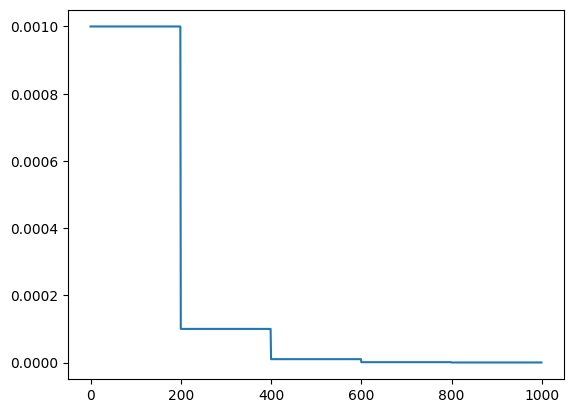

In [29]:
plt.plot([i for i in range(len(history["lr"]))], history["lr"])

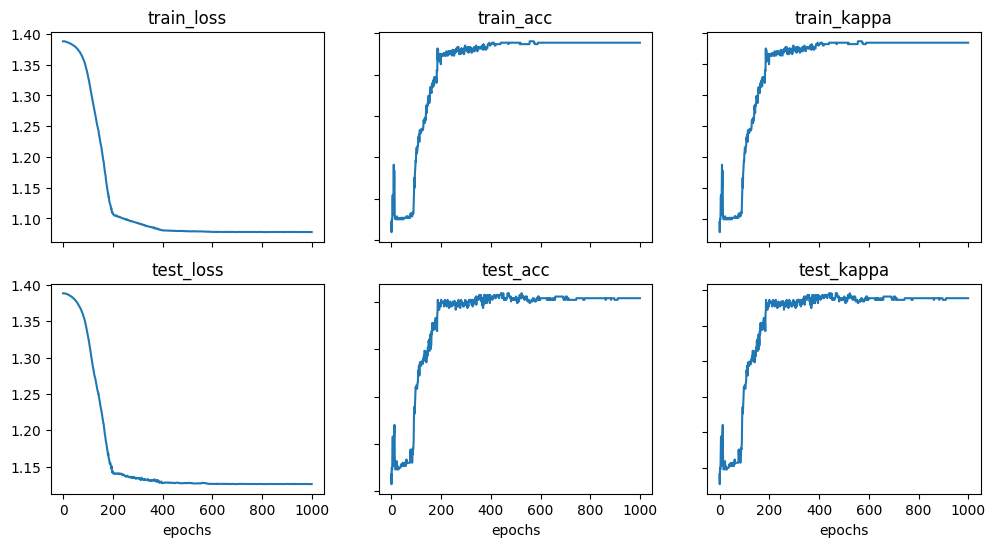

In [30]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [36]:
a = 0.3549382716049383
print(f"{a:.2}")

0.35
